<a href="https://colab.research.google.com/github/youssefsameh307/ACL_Task_1/blob/main/anomaly_detection_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### this notebook creates different reference models along with piplines for training and evaluating the models comparing them for use in anomaly detection as well on the OPCUA data


### the notebook is saved with the outputs so just open the cells and take a look at specific models and thier evaluation and performance(visually) when detecting anomalies

## mount colab (optional)

In [ ]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/Work/OPCUA'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)

# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)

# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['.ipynb_checkpoints', '4', 'AnomalyDetectionNoteBook.ipynb', 'Data_march2024', 'Empty_Data_understanding.ipynb', 'LSTM_Encoder_anomaly_Big', 'LSTM_Encoder_anomaly_Big_allCSVs', 'LSTM_VAE_Seq2Seq_big_allCSVs', 'LSTM_VAE_Seq2Seq_big_callbacked', 'LSTM_VAE_Seq2Seq_big_callbacked_chk2', 'LSTM_VAE_SinglePoint_big_allCSVs', 'LSTM_VAE_SinglePoint_big_allCSVs_chk3', 'LSTM_VAE_SinglePoint_big_allCSVschk2', 'LSTM_VAE_SinglePoint_big_callbacked_chk2', 'LSTM_anomaly', 'LSTM_anomaly_Mega2', 'LSTM_anomaly_Mega2_Bigger', 'LSTM_anomaly_Mega_correct_1', 'LSTM_anomaly_Mega_correct_Large', 'LSTM_anomaly_Mega_with_sesnsor_3M', 'LSTM_anomaly_Mega_with_sesnsor_3M_allCSVs', 'LSTM_anomaly_need_higher_LR', 'LSTM_forecast_more_data_cut', 'LSTM_forecast_more_data_cut_correct', 'LSTM_forecast_more_data_cut_correct_full_data', 'LSTM_forecast_more_data_cut_correct_full_data2', 'LSTM_forecast_more_data_cut_correct_over_reg', 'LSTM_forecast_more_data_cut_correct_over_reg_non_overlap', 'LST

# Load the *ALL* Data into Main set and test set

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [ ]:

import os
import pandas as pd

def load_dataframes(directory):
    dataframes = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            key = filename
            dataframes[key] = df
    return dataframes

In [ ]:
allSamples = load_dataframes('processed')
allSamples2 = load_dataframes('./Data_march2024/processed Data')

In [ ]:
names = list(list(allSamples.values())[0].keys())
targetName = [name for name in names if name.lower().find('usage') == -1 and name.lower().find('position') == -1 and name.lower().find('iserror') == -1 and name.lower().find('timestamp') == -1]

In [ ]:
# #Read the csv file
# df = list(allSamples.values())[0]
# df2 = list(allSamples2.values())[0]

In [ ]:
allSamples2.keys()

dict_keys(['SI0201434120240316175134.csv', 'SI0201434120240304112654.csv', 'SI423020240228124717.csv', 'SI423020230517082515.csv', 'SI423020230626121049.csv', 'SI0201434120230516142324.csv', 'SI423020231102090139.csv', 'SI423020231030142945.csv', 'SI423020240226100723.csv'])

In [ ]:
# path = f'./scalers/'
# os.makedirs(path, exist_ok=True)  # Create directory if it doesn't exist

In [ ]:
def get_scaler(all_df):
  scalers = {}
  for column in targetName:
    if(column != 'timestamp'):
      scaler = StandardScaler()
      col_data = all_df[column]
      scalers[column] = scaler.fit(np.array(all_df[column]).reshape(-1,1))
      joblib.dump(scaler, f'./scalers/scaler_{column}.pkl')

  return scalers

In [ ]:
def get_singular_scaler(all_df):
  all_df = all_df[targetName]
  scaler = StandardScaler()
  main_scaler = scaler.fit(all_df)
  joblib.dump(scaler, f'./scalers/main_scaler.pkl')

  return main_scaler

In [ ]:
def prepare_data(df_for_training, scalers, main_scaler=True):
  df_for_training = df_for_training.drop(['timestamp'],axis=1)
  df_for_training = df_for_training[targetName]
  df_for_training= df_for_training.bfill()
  df_for_training= df_for_training.ffill()

  if not main_scaler:
    for column in targetName:
        scaler = scalers[column]
        df_for_training[column] = scaler.transform(df_for_training[[column]])
  else:
    t_data = scalers.transform(df_for_training)
    df_for_training = pd.DataFrame(t_data, columns=df_for_training.columns)

  oldCount = len(df_for_training)
  numbersBefore.append(oldCount)
  print("number of samples before dropping nulls ", oldCount)

  df_for_training=df_for_training.dropna()
  numberRemoved.append(oldCount - len(df_for_training))
  print("samples dropped: ", oldCount - len(df_for_training))
  train_df_sample = df_for_training

  return train_df_sample

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

numbersBefore = []
numberRemoved = []

def prepareD(df_for_training):
  scalers = {}

  # Initialize the StandardScaler
  df_for_training = df_for_training[targetName]
  df_for_training= df_for_training.bfill()
  df_for_training= df_for_training.ffill()

  for column in targetName:
      if(column != 'timestamp'):
          scaler = StandardScaler()
          df_for_training[column] = scaler.fit_transform(df_for_training[[column]])
          # test[column] = scaler.transform(test[[column]])
          scalers[column] = scaler

  oldCount = len(df_for_training)
  numbersBefore.append(oldCount)
  print("number of samples before dropping nulls ", oldCount)

  df_for_training=df_for_training.dropna()
  numberRemoved.append(oldCount - len(df_for_training))
  print("samples dropped: ", oldCount - len(df_for_training))
  train_df_sample = df_for_training

  return train_df_sample, scalers

In [ ]:
# # run if you want to make new scalers otherwise load them

# all_data_frames = list(allSamples.values())[1:] + list(allSamples2.values())[1:]
# concatenated_df = pd.concat(all_data_frames, ignore_index=True)


In [ ]:
# # pick one of these to use

# main_scaler = get_singular_scaler(concatenated_df)
# # scalers_correct = get_scaler(concatenated_df)

In [ ]:
import joblib
scalers_correct = {}
for column in targetName:
    if(column != 'timestamp'):
      scalers_correct[column] = joblib.load(f'./scalers/scaler_{column}.pkl')

In [ ]:
main_scaler = joblib.load(f'./scalers/main_scaler.pkl')

In [ ]:
scalers_correct = main_scaler

In [ ]:
preparedAllSamples = {dfname:prepare_data(allSamples[dfname],scalers_correct) for dfname in list(allSamples.keys())[1:7]}
testSample = prepare_data(allSamples[list(allSamples.keys())[0]],scalers_correct)

number of samples before dropping nulls  2280941
samples dropped:  0
number of samples before dropping nulls  2251553
samples dropped:  0
number of samples before dropping nulls  2269805
samples dropped:  0
number of samples before dropping nulls  2264081
samples dropped:  0
number of samples before dropping nulls  2281364
samples dropped:  0
number of samples before dropping nulls  1548581
samples dropped:  0
number of samples before dropping nulls  2043385
samples dropped:  0


In [ ]:
preparedAllSamples2 = {dfname:prepare_data(allSamples2[dfname],scalers_correct) for dfname in list(allSamples2.keys())[1:7]}

testSample2 = prepare_data(allSamples2[list(allSamples2.keys())[0]],scalers_correct)

number of samples before dropping nulls  2294299
samples dropped:  0
number of samples before dropping nulls  2264813
samples dropped:  0
number of samples before dropping nulls  2496444
samples dropped:  0
number of samples before dropping nulls  442055
samples dropped:  0
number of samples before dropping nulls  453505
samples dropped:  0
number of samples before dropping nulls  500664
samples dropped:  0
number of samples before dropping nulls  2482022
samples dropped:  0


# number of samples removed when dropping nulls

In [ ]:
numbersBefore

[2280941,
 2251553,
 2269805,
 2264081,
 2281364,
 1548581,
 2043385,
 2294299,
 2264813,
 2496444,
 442055,
 453505,
 500664,
 2482022]

In [ ]:
numberRemoved

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Sampling Data for a train set

In [ ]:
import random
import tensorflow as tf
window_size = 14

trainX=None
trainY=None
currentCSV=1
samples_count=400000

#remove the additional concatenation of P.A.S.2
for dfc in list(preparedAllSamples.values()) + list(preparedAllSamples2.values()):
    random_samples = random.sample(range(len(dfc[0])-window_size), samples_count)
    data = dfc[0]
    target = dfc[0]
    print('started CSV #', currentCSV+1)
    currentCSV = currentCSV + 1

    X_batch = np.array([data[i:i+window_size-1] for i in random_samples])
    Y_batch = np.array([target[i+window_size-1:i+window_size] for i in random_samples])

    if trainX is None:
        trainX = X_batch
        trainY = Y_batch
    else:
        trainX = np.concatenate((trainX, X_batch))
        trainY = np.concatenate((trainY, Y_batch))

X = trainX
Y = trainY

#Isolation Forest

### sample evaluation below on one of the sensors that contains visual anomalies, However it works on analyzing all of the sesnors but the rest of the readings appear to not have anomalies.

### at the last 2 cells of these blocks the anomalies are indicated with -1

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest

In [ ]:
import random
import tensorflow as tf
window_size = 30

trainX=[]
trainY=None
samples_count=1000000

for dfc in list(preparedAllSamples.values()):
  data = dfc[0].values
  print(type(data))
  target = dfc[0]['Laser 1 temperature']
  if len(trainX) == 0:
    trainX = data
  else:
    trainX = np.concatenate((trainX, data), axis=0)


X = np.array(trainX)
Y = np.array(trainY)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
testX = testSample[0].values

In [ ]:
model = IsolationForest(contamination=0.003)  # Adjust the contamination parameter based on your data

# Fit the model to your data
model.fit(trainX)

IsolationForest(contamination=0.003)

In [ ]:
testX = testSample[0].drop(columns=['anomaly'])

In [ ]:
train_df_sample_isolation = testX
train_df_sample_isolation['anomaly'] = model.predict(train_df_sample_isolation)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [ ]:
# Anomalies are labeled as -1, normal instances as 1
anomalies = train_df_sample_isolation[train_df_sample_isolation['anomaly'] == -1]
anomalies

layerIndex  Absolute process chamber humidity  \
1071298    0.323758                          11.019051   
1071299    0.323758                          11.019051   
1071300    0.323758                          11.019051   
1071301    0.323758                          11.019051   
1071302    0.323758                          11.019051   
...             ...                                ...   
1639042    0.933360                           1.896453   
1639043    0.933360                           1.896453   
1639044    0.933360                           1.896453   
1639045    0.933360                           1.896453   
1639046    0.933360                           1.896453   

         Building platform temperature  Dosage factor  Inertgas inlet valve  \
1071298                      -1.094138      -0.029593             -0.209399   
1071299                      -1.094138      -0.029593             -0.209399   
1071300                      -1.094138      -0.029593             -0.209399   
1071301                      -1.094138      -0.029593             -0.209399   
1071302                      -1.094138      -0.029593             -0.209399   
...                                ...            ...                   ...   
1639042                      -1.094138      -0.029593             15.918692   
1639043                      -1.094138      -0.029593             15.918692   
1639044                      -1.094138      -0.029593             15.918692   
1639045                      -1.094138      -0.029593             15.918692   
1639046                      -1.094138      -0.029593             15.918692   

         Laser 1 temperature  Oxygen concentration at top of process chamber  \
1071298            -4.800593                                       20.041738   
1071299            -4.800593                                       20.041738   
1071300            -4.800593                                       20.041738   
1071301            -4.800593                                       20.041738   
1071302            -4.800593                                       20.041738   
...                      ...                                             ...   
1639042            -5.037636                                        0.001816   
1639043            -5.037636                                        0.001816   
1639044            -5.037636                                        0.001816   
1639045            -5.037636                                        0.001816   
1639046            -5.037636                                        0.001816   

         Oxygen concentration in Recirculating filter system  \
1071298                                          -1.084948     
1071299                                          -1.084948     
1071300                                          -1.084948     
1071301                                          -1.084948     
1071302                                          -1.084948     
...                                                    ...     
1639042                                          -1.084948     
1639043                                          -1.084948     
1639044                                          -1.084948     
1639045                                          -1.084948     
1639046                                          -1.084948     

         Process chamber temperature  RFS filter pressure drop  \
1071298                    -0.844489                 -2.573703   
1071299                    -0.844489                 -2.573703   
1071300                    -0.844489                 -2.573703   
1071301                    -0.844489                 -2.573703   
1071302                    -0.844489                 -2.573703   
...                              ...                       ...   
1639042                     0.673084                 -1.644691   
1639043                     0.673084                 -1.644691   
1639044                     0.673084   

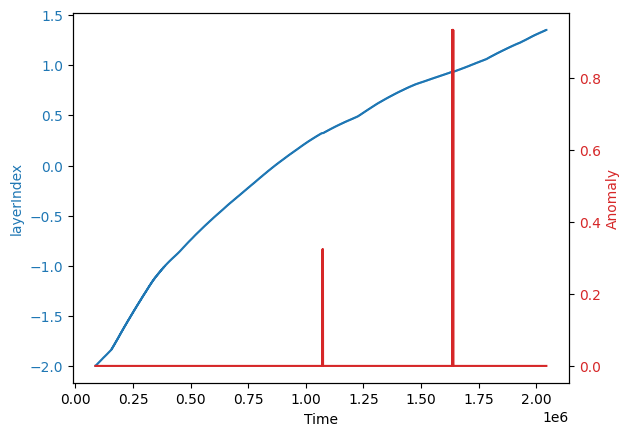

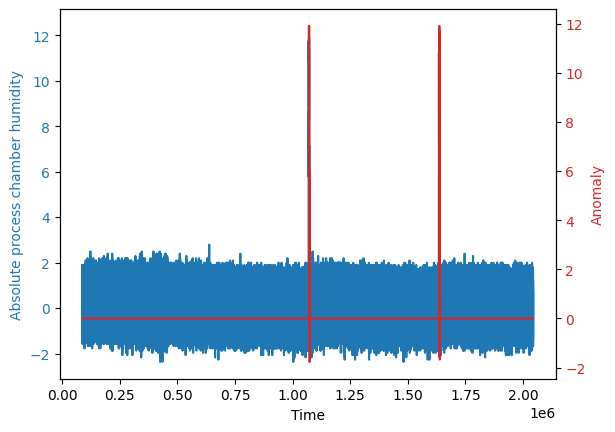

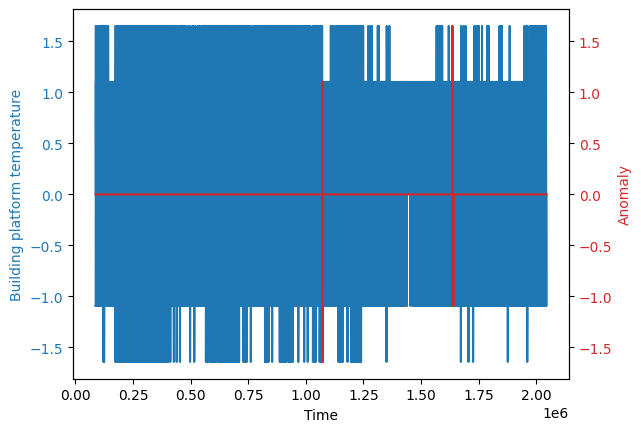

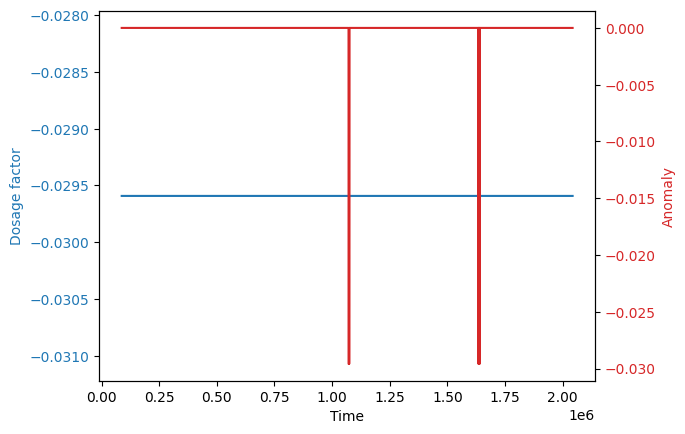

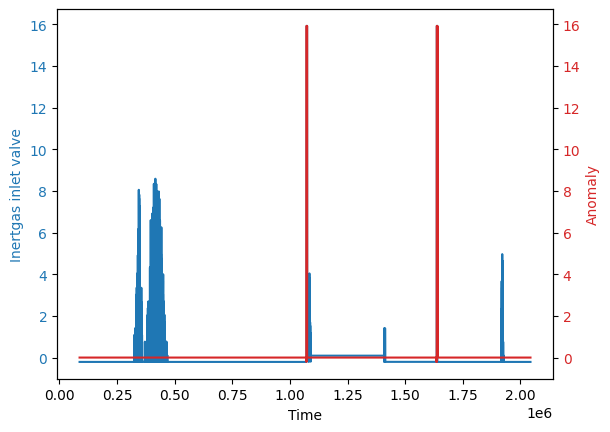

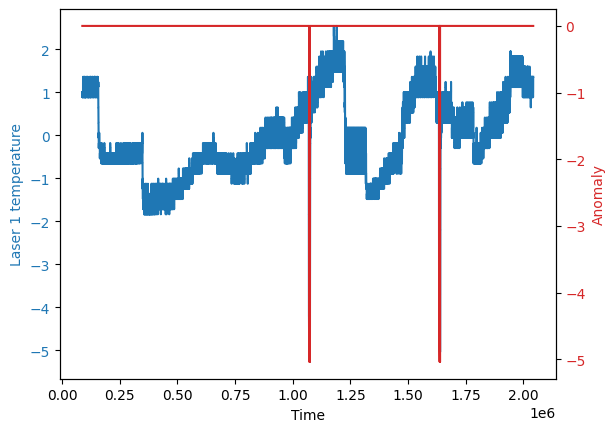

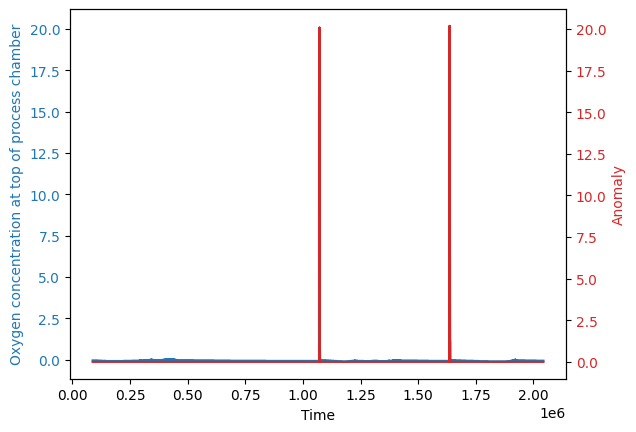

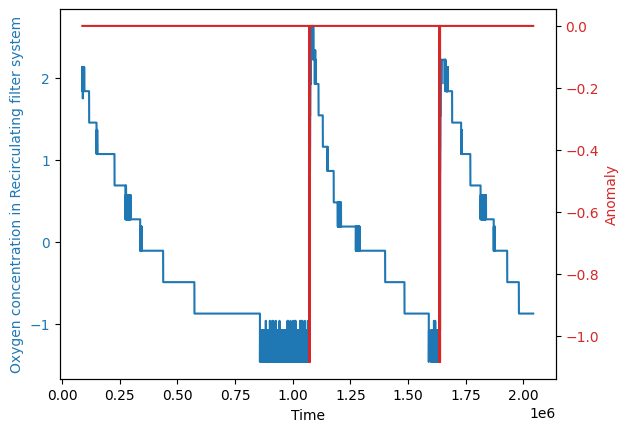

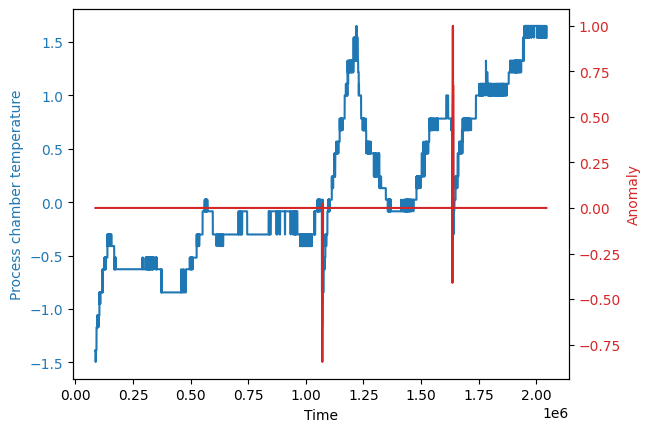

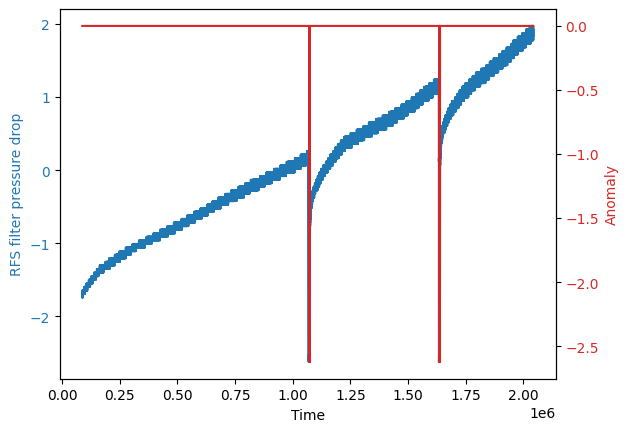

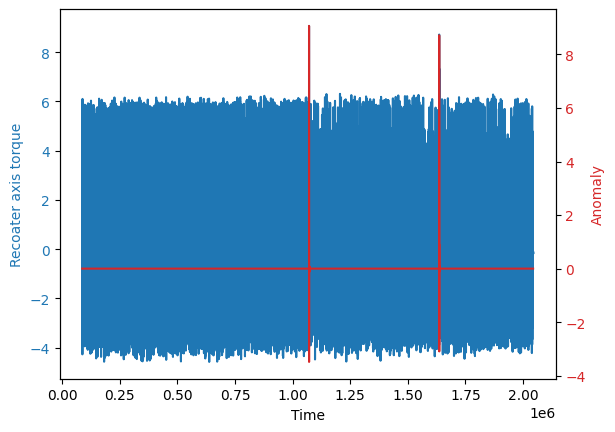

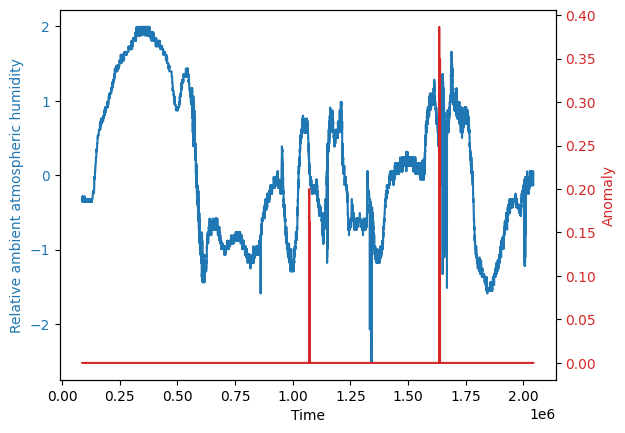

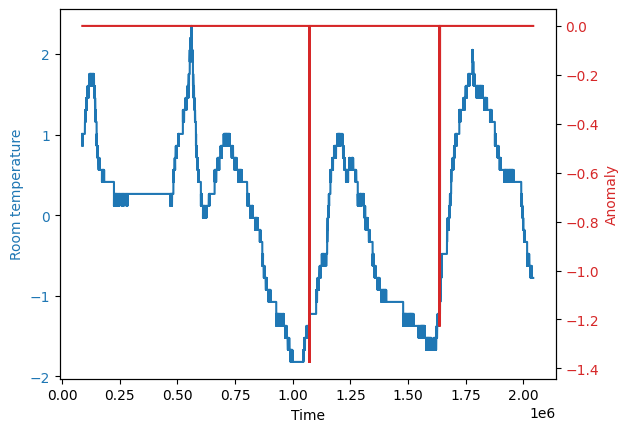

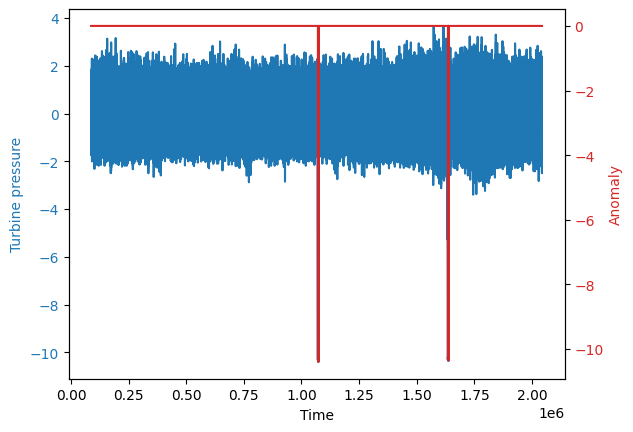

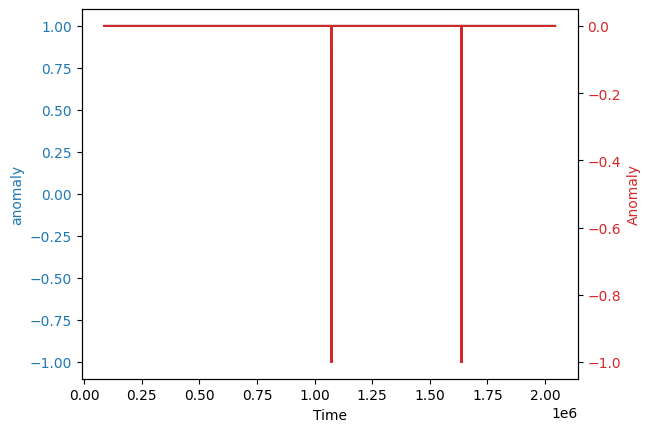

In [ ]:
import matplotlib.pyplot as plt

for colName in train_df_sample_isolation.keys():
  # Assuming train_df_sample_isolation is your DataFrame
  fig, ax1 = plt.subplots()

  # Filter the 'Laser 1 temperature' values based on the 'anomaly' column
  anomaly_values = train_df_sample_isolation[colName].where(train_df_sample_isolation['anomaly'] == -1, 0)

  # Plotting 'Laser 1 temperature' on the left y-axis
  color = 'tab:blue'
  ax1.set_xlabel('Time')
  ax1.set_ylabel(colName, color=color)
  ax1.plot(train_df_sample_isolation[colName], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  # Creating a second y-axis for 'anomaly'
  ax2 = ax1.twinx()
  color = 'tab:red'
  ax2.set_ylabel('Anomaly', color=color)
  ax2.plot(anomaly_values, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  plt.show()

# LSTM forcast

## LSTM Forecast for one sensor Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense

dim1 = X.shape[1]
dim2 = X.shape[2]
outdim = Y.shape[1]

In [ ]:
noise_array = np.random.normal(loc=0, scale=0.04, size=X.shape)

In [ ]:
X = X + noise_array

In [ ]:
window_sensor_counts = np.zeros((X.shape[0]), dtype=int)

for i in range(X.shape[0]):
    window_data = X[i, :, :]

    # Use NumPy's unique function to get unique elements and their counts for each window
    unique_elements, counts = np.unique(window_data, axis=0, return_counts=True)
    print(unique_elements)
    # Sum the counts for each sensor and store in the result array
    window_sensor_counts[i] = max(counts)

print("Window 1 Sensor Counts:")
for sensor_index, count in enumerate(window_sensor_counts[:]):
    print(f"Sensor {sensor_index + 1}: {count}")

In [ ]:
type(X)

numpy.ndarray

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

In [ ]:
from tensorflow.keras.regularizers import l1, l2

model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(dim1, dim2), kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False, kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(outdim))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 13, 128)           73216     
                                                                 
 dropout_6 (Dropout)         (None, 13, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 13, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 13, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
model.compile(optimizer=optimizer, loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 13, 128)           73216     
                                                                 
 dropout_6 (Dropout)         (None, 13, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 13, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 13, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
import tensorflow as tf

# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available.")
    # Check if CUDA is available
    if tf.test.is_built_with_cuda():
        print("CUDA is available.")
        # Print CUDA version
        print("CUDA version:", tf.test.gpu_device_name())
    else:
        print("CUDA is not available.")
else:
    print("GPU is not available.")

GPU is available.
CUDA is available.
CUDA version: /device:GPU:0


In [ ]:
history = model.fit(X, Y, epochs=10, batch_size=256, validation_split=0.2, verbose=1)

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend() # increase learning rate to 10^-3

In [ ]:
model.save('LSTM_anomaly_need_higher_LR')

## LSTM-Forecast for one sensor Prediction and evaluation

### the difference between the forecast and actual values is calculated and thresholding is applied to detect anomalies, unlike the previous approach this works on forecasting one sensor.

In [ ]:
import tensorflow as tf

window_size=29

testInput = testSample[0]
# .drop(columns=['Laser 1 temperature'])
testTarget = testSample[0]['Laser 1 temperature']

testX = np.array([testInput[i:i+window_size].values for i in range(len(testInput)-window_size)])

In [ ]:
testX.shape

(1956107, 29, 14)

In [ ]:
testX = testX[:,:,:14]

In [ ]:
testX.shape

(1956107, 29, 14)

In [ ]:
model = tf.keras.models.load_model('LSTM_anomaly_Mega_with_sesnsor_3M_allCSVs')

In [ ]:
model

In [ ]:
testX[0]

array([[-1.99503609,  1.20234244, -1.09413834, -0.0295927 , -0.20939902,
         1.00695528, -0.03910657,  2.13400303, -1.38647997, -1.69358626,
        -0.12795531, -0.32241434,  1.00785783, -0.14609669],
       [-1.99503609,  1.20234244, -1.09413834, -0.0295927 , -0.20939902,
         1.00695528, -0.03910657,  2.13400303, -1.38647997, -1.69358626,
        -0.0999832 , -0.32241434,  1.00785783, -0.14609669],
       [-1.99503609,  1.20234244, -1.09413834, -0.0295927 , -0.20939902,
         1.00695528, -0.03910657,  2.13400303, -1.38647997, -1.69358626,
        -0.0999832 , -0.32241434,  1.00785783, -0.14609669],
       [-1.99503609,  0.21075574, -1.09413834, -0.0295927 , -0.20939902,
         1.00695528, -0.03910657,  2.13400303, -1.38647997, -1.69358626,
        -0.0999832 , -0.32241434,  1.00785783, -0.14609669],
       [-1.99503609,  0.21075574, -1.09413834, -0.0295927 , -0.20939902,
         1.00695528, -0.03910657,  2.13400303, -1.38647997, -1.69358626,
        -0.0999832 , -0.32

In [ ]:
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

61129/61129 [==============================] - 630s 10ms/step


In [ ]:
y_pred_future = testSample[1]['Laser 1 temperature'].inverse_transform(prediction)
y_pred_future

array([[26.797825],
       [26.797832],
       [26.797863],
       ...,
       [27.097275],
       [27.096811],
       [27.096582]], dtype=float32)

In [ ]:
y_dif = np.zeros(y_pred_future.shape)
y_dif.shape

(1956107, 1)

In [ ]:
groundTruth = np.array(testSample[0]['Laser 1 temperature'].values)

In [ ]:
for i in range(len(y_pred_future)):
  y_dif[i] = prediction[i] - groundTruth[i]

In [ ]:
y_dif = np.abs(y_dif)

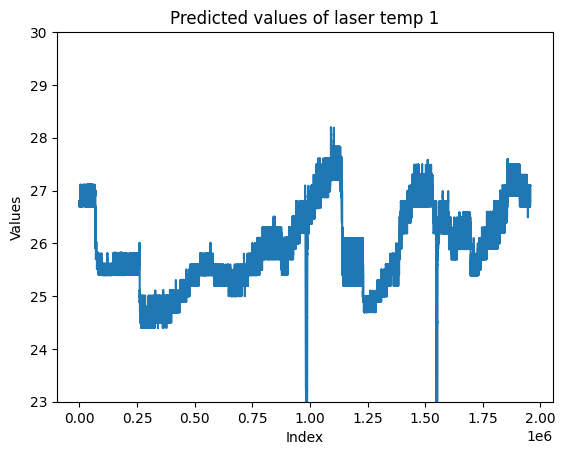

In [ ]:
plt.plot(y_pred_future)

plt.ylim([23, 30])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted values of laser temp 1')

# Display the plot
plt.show()

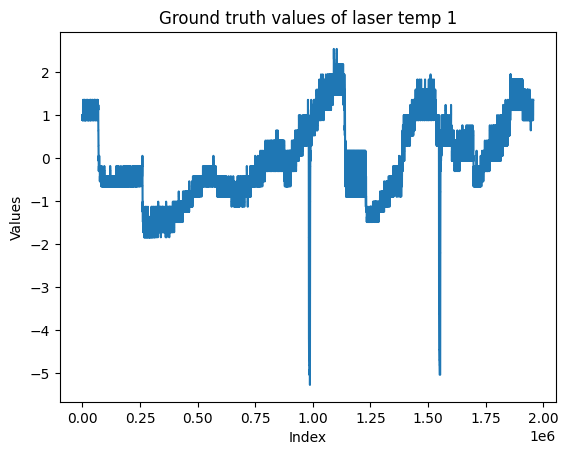

In [ ]:
plt.plot(groundTruth)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Ground truth values of laser temp 1')

# Display the plot
plt.show()

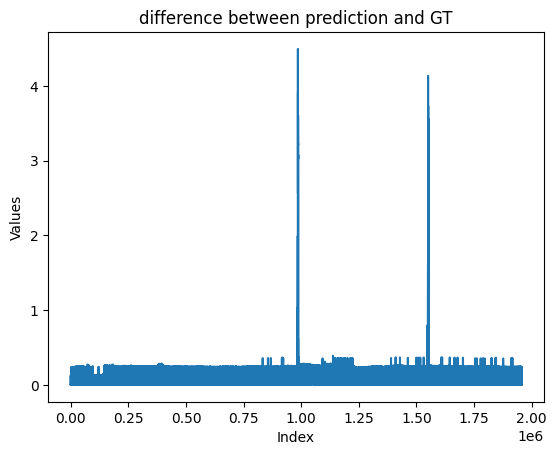

In [ ]:
plt.plot(y_dif)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('difference between prediction and GT')

# Display the plot
plt.show()

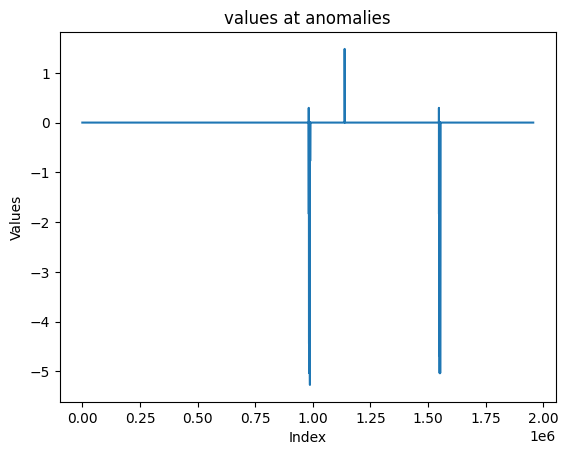

In [ ]:
y_threshold = [ testSample[0]['Laser 1 temperature'].values[i] if y >0.37 else 0 for i,y in enumerate(y_dif)]
plt.plot(y_threshold)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('values at anomalies')

# Display the plot
plt.show()

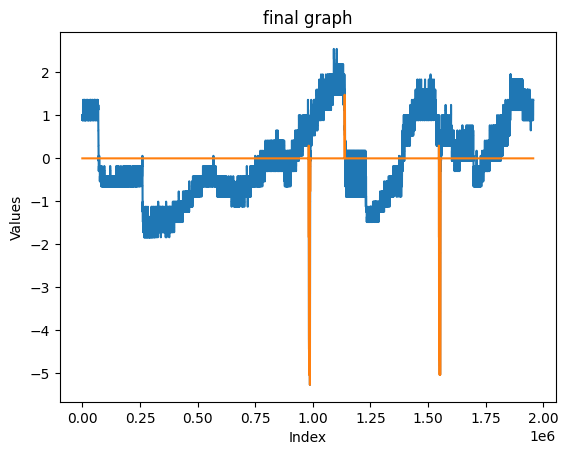

In [ ]:
plt.plot(testSample[0]['Laser 1 temperature'].values)
plt.plot(y_threshold)
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('final graph')

# Display the plot
plt.show()

# Sequence to Sequence LSTM AutoEncoder

### this works on reconstructing a whole window and trying to detect whether it is anomalous or not throught the reconstruction difference after learning the normal patterns of the data, again thresholding is applied on the difference

In [ ]:
import random
import tensorflow as tf
window_size = 10

trainX=None
samples_count=700000
currentCSV=1
for dfc in list(preparedAllSamples.values()) + list(preparedAllSamples2.values()) :
  random_samples = random.sample(range(len(dfc[0])-window_size), samples_count)
  data = dfc[0]
  print('started CSV # :', currentCSV+1)
  currentCSV = currentCSV + 1

  if trainX == None:
    trainX = [data[i:i+window_size-1] for i in random_samples]
  else:
    trainX += [data[i:i+window_size-1] for i in random_samples]

X = np.array(trainX)

started CSV # : 2
started CSV # : 3
started CSV # : 4
started CSV # : 5
started CSV # : 6
started CSV # : 7


In [ ]:
np.random.shuffle(X)

In [ ]:
import tensorflow as tf

window_size=9

testInput = testSample[0]
testX = np.array([testInput[i:i+window_size].values for i in range(len(testInput)-window_size)])
testX = testX[:,:,:14]

In [ ]:
import tensorflow as tf

window_size=9

testInput2 = testSample2[0]
testX = np.array([testInput2[i:i+window_size].values for i in range(len(testInput2)-window_size)])
testX = testX[:,:,:14]

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns




In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)

model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu', return_sequences=False))


model.add(RepeatVector(X.shape[1]))

model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(512, activation='relu', return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(TimeDistributed(Dense(X.shape[2])))

model.compile(optimizer=optimizer, loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 512)            1079296   
                                                                 
 batch_normalization (Batch  (None, 9, 512)            2048      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 9, 256)            787456    
                                                                 
 batch_normalization_1 (Bat  (None, 9, 256)            1024      
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 repeat_vector (RepeatVecto  (None, 9, 128)            0

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('seq2seqLSTM_autoencoder_20_iter_best_1', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [ ]:
history = model.fit(X, X, epochs=14, batch_size=256, validation_split=0.2, verbose=1,callbacks=[checkpoint])

Epoch 1/14
20625/20625 [==============================] - ETA: 0s - loss: 0.1347
Epoch 1: val_loss improved from inf to 0.05637, saving model to seq2seqLSTM_autoencoder_20_iter_best_1
20625/20625 [==============================] - 1003s 49ms/step - loss: 0.1347 - val_loss: 0.0564
Epoch 2/14
20624/20625 [============================>.] - ETA: 0s - loss: 0.1268
Epoch 2: val_loss improved from 0.05637 to 0.04993, saving model to seq2seqLSTM_autoencoder_20_iter_best_1
20625/20625 [==============================] - 993s 48ms/step - loss: 0.1268 - val_loss: 0.0499
Epoch 3/14
20625/20625 [==============================] - ETA: 0s - loss: 0.1202
Epoch 3: val_loss improved from 0.04993 to 0.04387, saving model to seq2seqLSTM_autoencoder_20_iter_best_1
20625/20625 [==============================] - 997s 48ms/step - loss: 0.1202 - val_loss: 0.0439
Epoch 4/14
20625/20625 [==============================] - ETA: 0s - loss: 0.1167
Epoch 4: val_loss improved from 0.04387 to 0.04232, saving model to se

In [ ]:
model.save('seq2seqLSTM_autoencoder_20_iter_best')

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
# model = tf.keras.models.load_model('LSTM_Encoder_anomaly_Big_allCSVs')
model = tf.keras.models.load_model('seq2seqLSTM_autoencoder_20_iter_best')


In [ ]:
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

77563/77563 [==============================] - 764s 10ms/step


In [ ]:
flattenedTest = testX.reshape(-1, testX.shape[-1])

In [ ]:
noise = np.random.normal(loc=0, scale=0.25, size=flattenedTest.shape)

In [ ]:
noisyTest = flattenedTest + noise

In [ ]:
noisyTestData = noisyTest.reshape(-1,9,14)

In [ ]:
noisyPrediction = model.predict(noisyTestData) #shape = (n, 1) where n is the n_days_for_prediction

61129/61129 [==============================] - 601s 10ms/step


In [ ]:
prediction = noisyPrediction

## loop Test

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf


window_size=9

for testInput2 in testSample2:

  testX = np.array([testInput2[i:i+window_size].values for i in range(len(testInput2)-window_size)])
  testX = testX[:,:,:14]
  prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction
  plt.plot(testX[:,5])

  # Adding labels and title
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title('L2 norm of the whole window across time')

  # Display the plot
  plt.show()



  a = testX.reshape((1956127*9, 14))
  b = prediction.reshape(1956127*9,14)
  a1 = a[:,5][:1000000]
  b1= b[:,5][:1000000]
  plt.plot(a1, label='Sensor Readings')
  plt.plot(b1, label='Sensor Predictions')

  plt.xlabel('Data Point')
  plt.ylabel('Value')
  plt.title('Sensor Readings vs Sensor Predictions')
  plt.legend()

  plt.show()

  l2_norm = np.linalg.norm(prediction - testX, axis=(1, 2))

  plt.plot(l2_norm)

  plt.ylim([0, 40])
  # Adding labels and title
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title('L2 norm of the whole window across time')

  # Display the plot
  plt.show()


  for sensorName in targetName:
    y_threshold = [ testSample[0][sensorName].values[i+5] if y >4.5 else 0 for i,y in enumerate(l2_norm)]

    plt.plot(testSample[0][sensorName].values)
    plt.plot(y_threshold)
    # Adding labels and title
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(sensorName+' anomalies')

    # Display the plot
    plt.show()

## loop test end


#### re run the cells below and then the loop test above

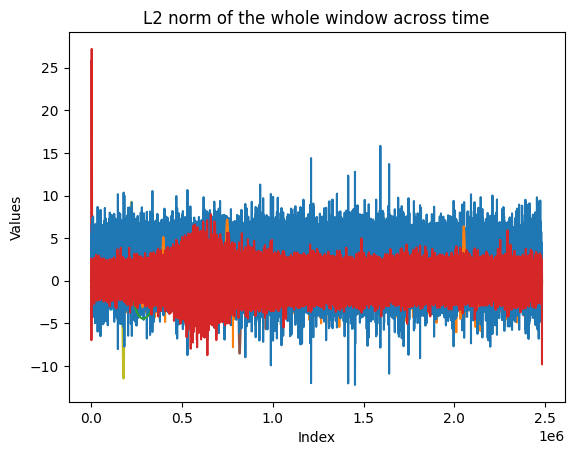

In [ ]:
plt.plot(testX[:,5])

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('L2 norm of the whole window across time')

# Display the plot
plt.show()

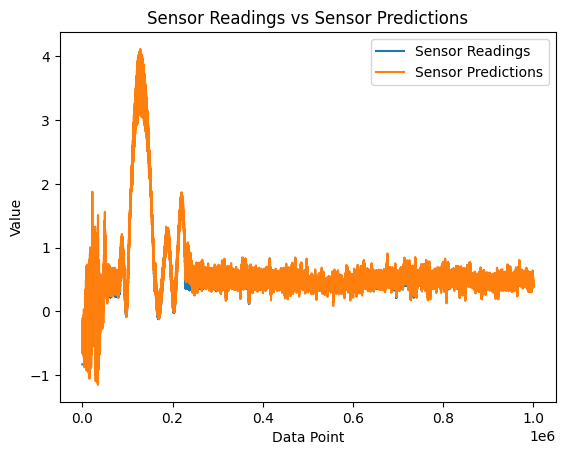

In [ ]:
import matplotlib.pyplot as plt
a = testX.reshape((testX.shape[0]*9, 14))
b = prediction.reshape(testX.shape[0]*9,14)
a1 = a[:,5][:1000000]
b1= b[:,5][:1000000]
plt.plot(a1, label='Sensor Readings')
plt.plot(b1, label='Sensor Predictions')

plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Sensor Readings vs Sensor Predictions')
plt.legend()

plt.show()


## Sequence to Sequence LSTM AutoEncoder evaluation and anomaly detection with thretholding


### the actual evaluation with absolute difference and l2 norm between reconstruction and data for comparison

## using L2 norm between prediction and target

In [ ]:
l2_norm = np.linalg.norm(prediction - testX, axis=(1, 2))


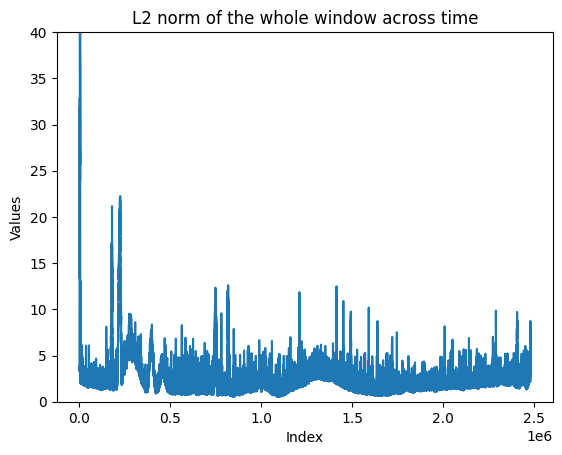

In [ ]:
plt.plot(l2_norm)

plt.ylim([0, 40])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('L2 norm of the whole window across time')

# Display the plot
plt.show()

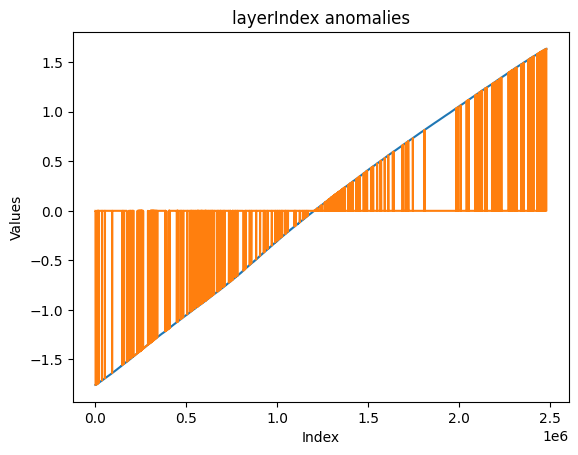

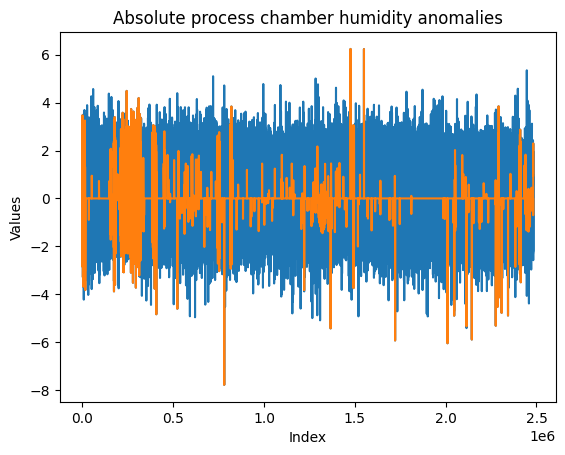

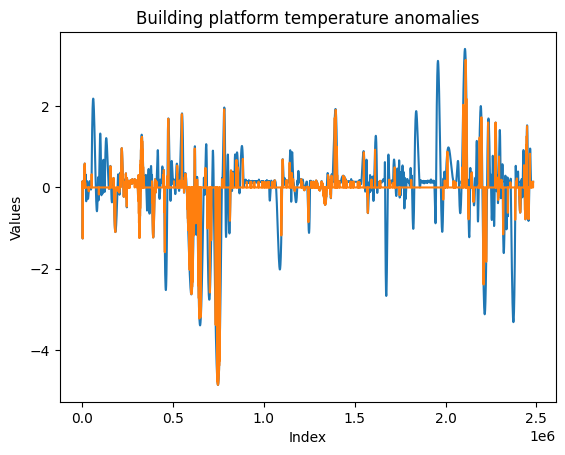

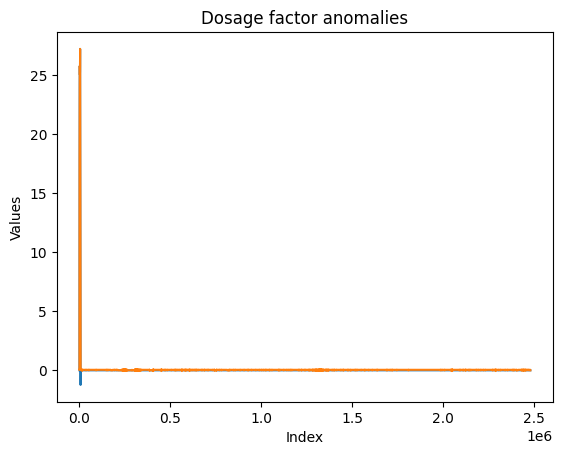

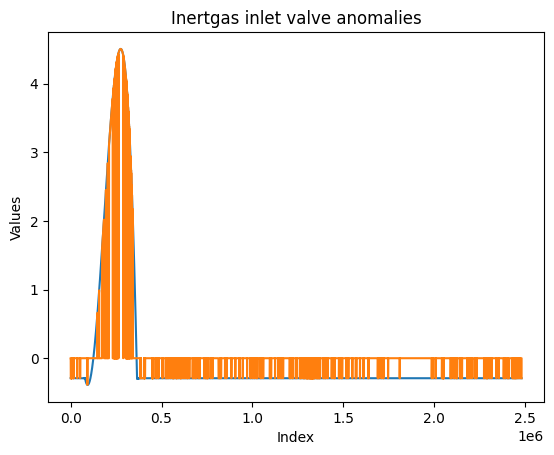

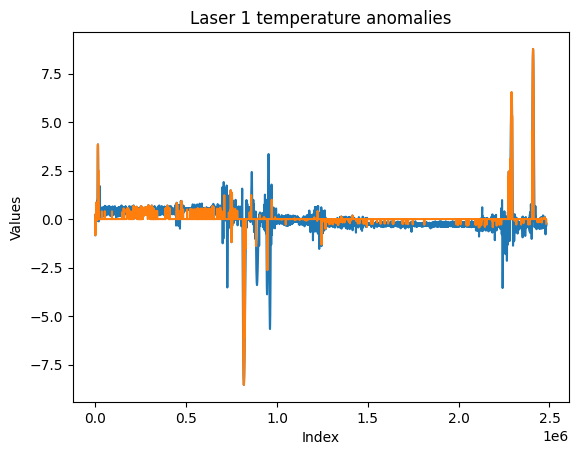

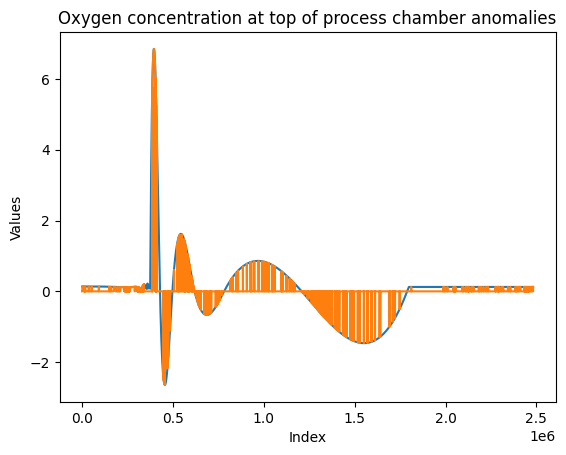

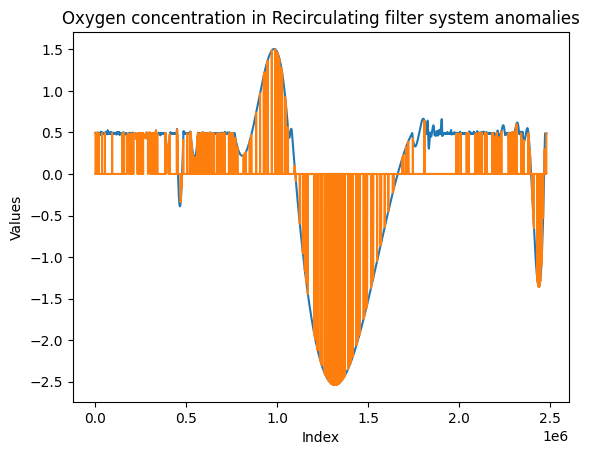

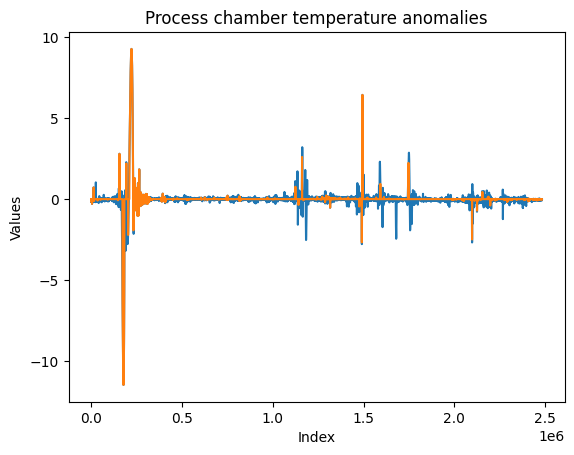

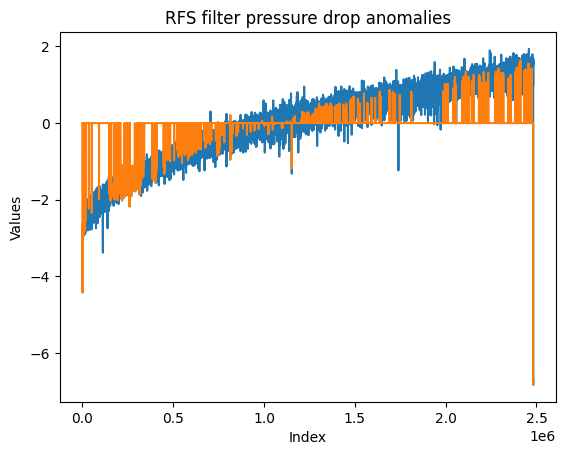

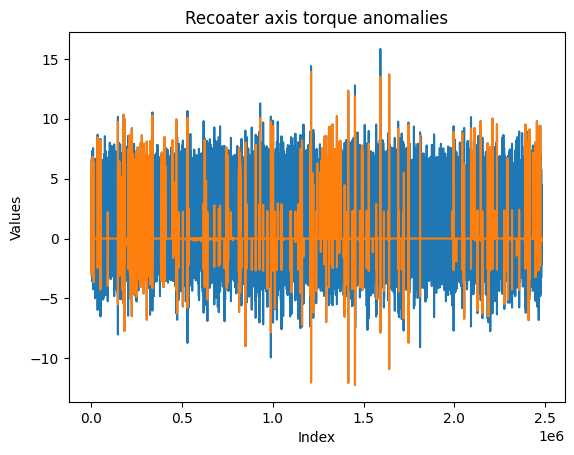

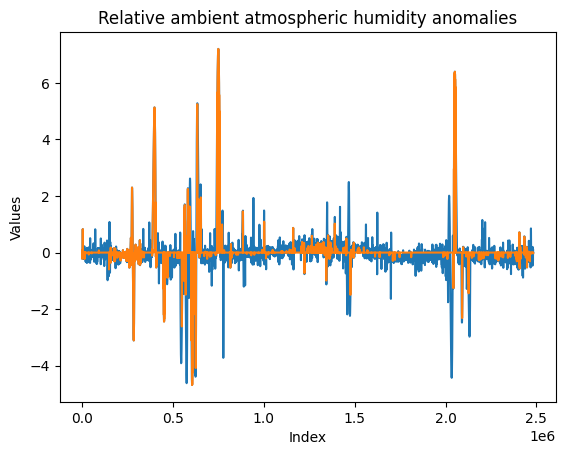

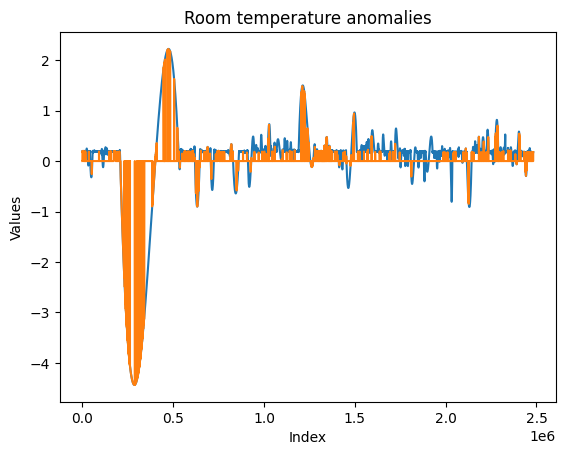

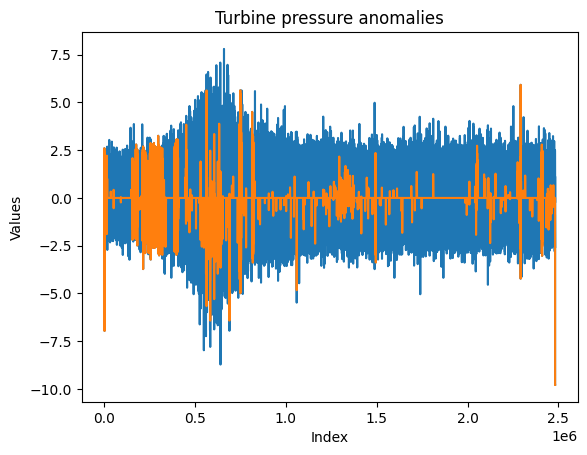

In [ ]:
for sensorName in targetName:
  y_threshold = [ testSample[0][sensorName].values[i+5] if y >4.5 else 0 for i,y in enumerate(l2_norm)]

  plt.plot(testSample[0][sensorName].values)
  plt.plot(y_threshold)
  # Adding labels and title
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title(sensorName+' anomalies')

  # Display the plot
  plt.show()

## using L1 mean absolute difference

In [ ]:
l1_norm = np.mean(np.abs(prediction - testX), axis=(1, 2))

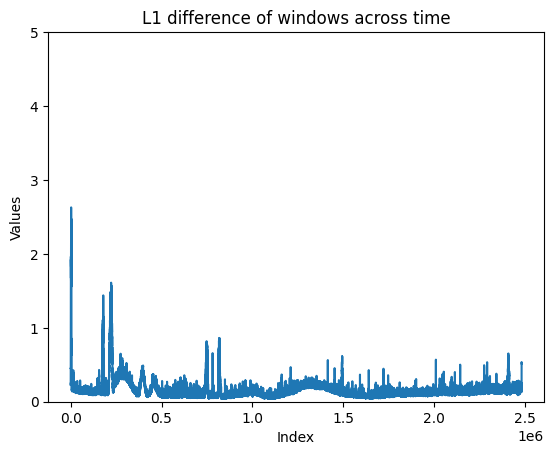

In [ ]:
plt.plot(l1_norm)

plt.ylim([0, 5])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('L1 difference of windows across time')

# Display the plot
plt.show()

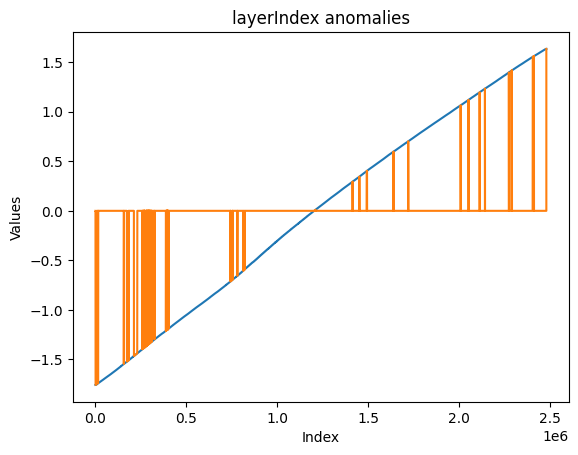

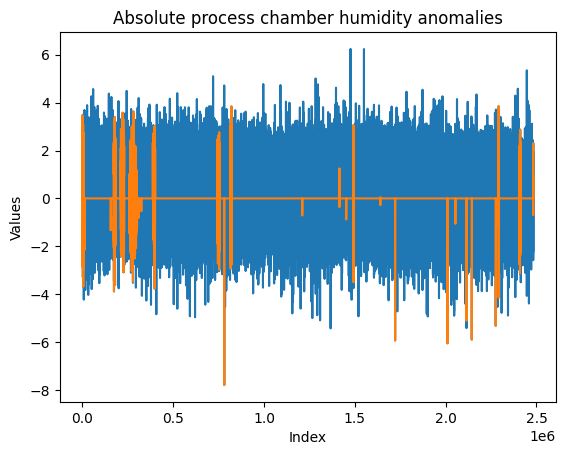

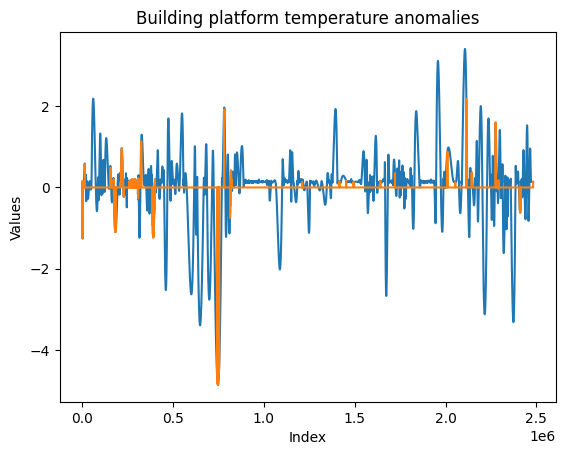

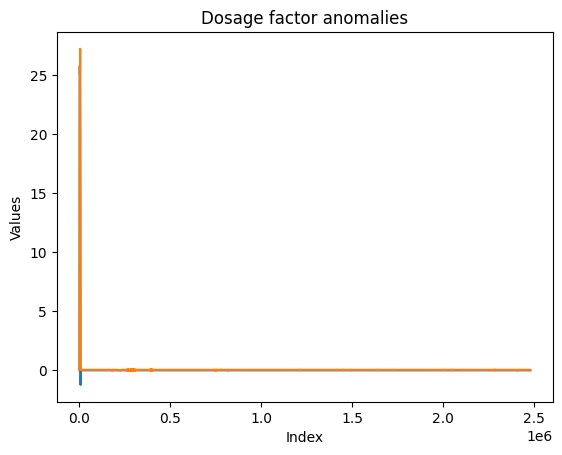

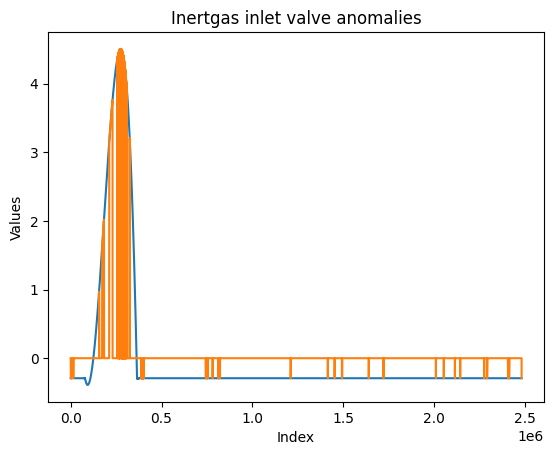

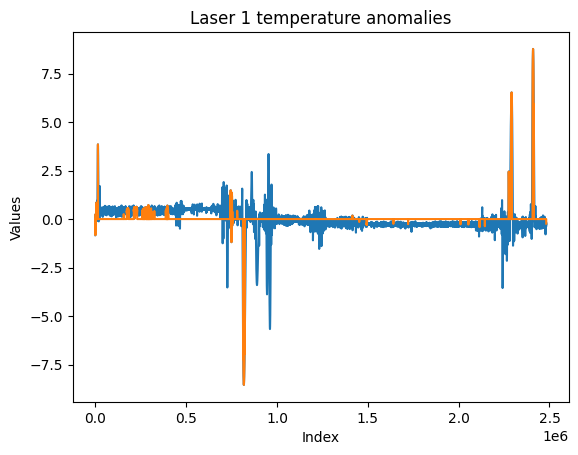

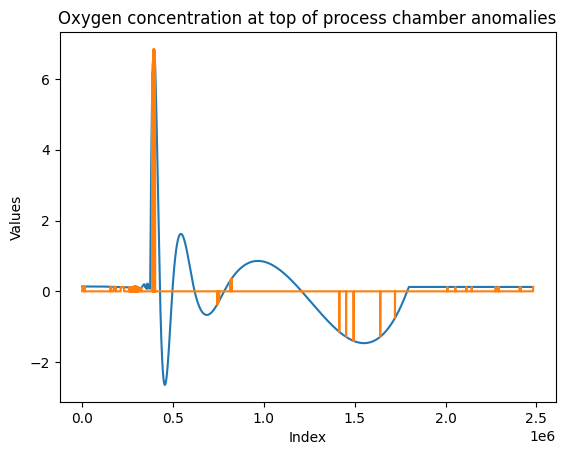

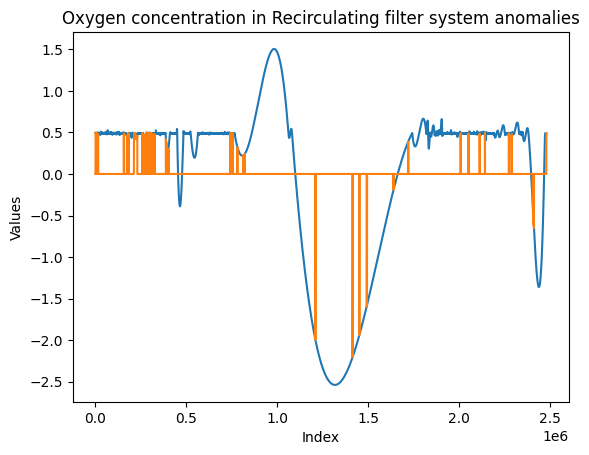

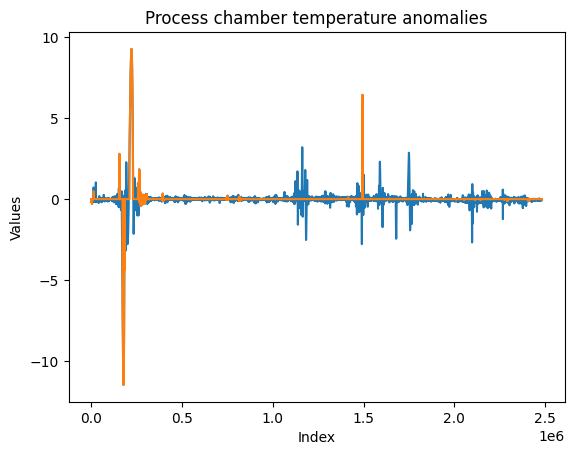

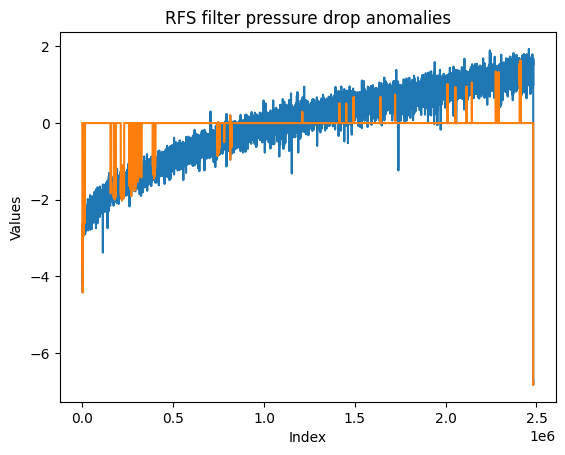

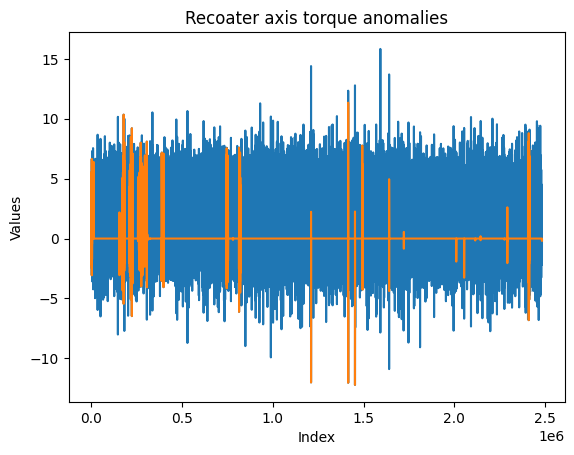

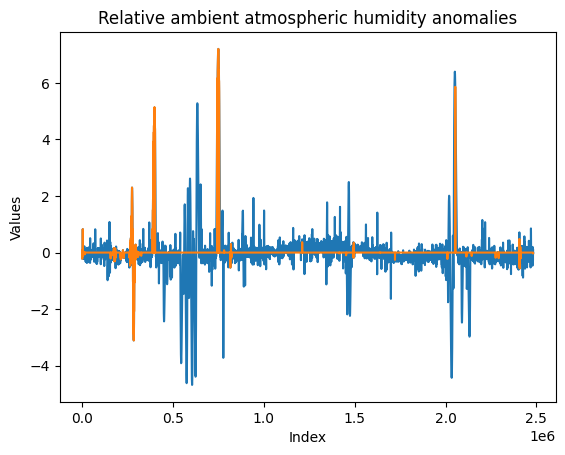

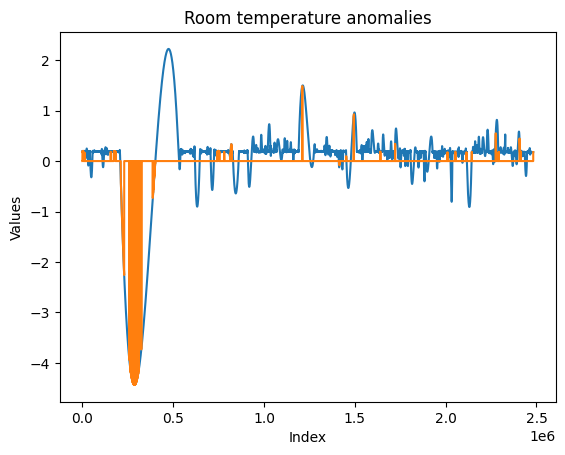

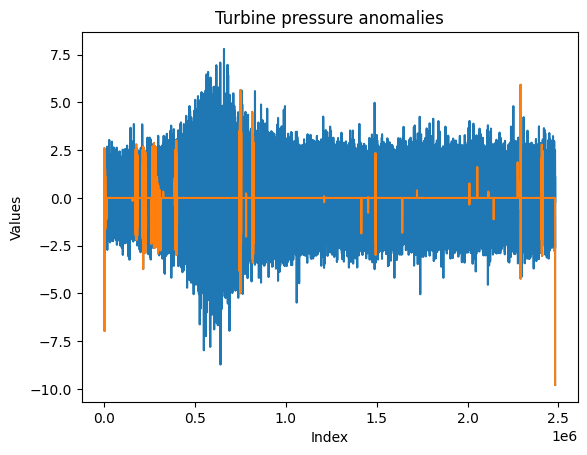

In [ ]:
for sensorName in targetName:
  y_threshold = [ testSample2[0][sensorName].values[i+5] if y >0.4 else 0 for i,y in enumerate(l1_norm)]

  plt.plot(testSample2[0][sensorName].values)
  plt.plot(y_threshold)
  # Adding labels and title
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title(sensorName+' anomalies')

  # Display the plot
  plt.show()

# LSTM-Forecast for multiple sensors

In [ ]:
import random
import tensorflow as tf
window_size = 30

X=None
Y=None
currentCSV=1
samples_count=350000

#remove the additional concatenation of P.A.S.2
for dfc in list(preparedAllSamples.values()) + list(preparedAllSamples2.values()):
    random_samples = random.sample(range(len(dfc)-window_size), samples_count)
    data = dfc
    print('started CSV #', currentCSV+1)
    currentCSV = currentCSV + 1

    X_batch = np.array([data[i:i+window_size-1] for i in random_samples])
    Y_batch = np.array([data[i+window_size-1:i+window_size] for i in random_samples])

    if X is None:
        X = X_batch
        Y = Y_batch
    else:
        X = np.concatenate((X, X_batch))
        Y = np.concatenate((Y, Y_batch))

started CSV # 2
started CSV # 3
started CSV # 4
started CSV # 5
started CSV # 6
started CSV # 7
started CSV # 8
started CSV # 9
started CSV # 10
started CSV # 11
started CSV # 12
started CSV # 13


In [ ]:
Y = Y.reshape((Y.shape[0],Y.shape[-1]))

In [ ]:
Y.shape

In [ ]:
import tensorflow as tf

window_size=29

testInput = testSample
# .drop(columns=['Laser 1 temperature'])
# testTarget = testSample[0]['Laser 1 temperature']

testX = np.array([testInput[i:i+window_size].values for i in range(len(testInput)-window_size)])
testY = np.array([testInput[i+window_size:i+window_size+1].values for i in range(len(testInput)-window_size)])

In [ ]:
testY = testY.reshape((testY.shape[0],testY.shape[-1]))

In [ ]:
testY.shape

In [ ]:
testY.shape

In [ ]:
testX = testX[:,:,:14]

In [ ]:
testX.shape

## new model

In [ ]:
dim1 = X.shape[1]
dim2 = X.shape[2]
dimout = Y.shape[-1]

In [ ]:
dimout

In [ ]:
from tensorflow.keras.regularizers import l1, l2

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Sequential()

model.add(LSTM(512, activation='relu', return_sequences=True, input_shape=(dim1, dim2),
              #  kernel_regularizer=l1(0.0005), recurrent_regularizer=l2(0.0005)
               ))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu', return_sequences=False, kernel_regularizer=l1(0.0005), recurrent_regularizer=l2(0.0009)))
model.add(Dense(dimout))

model.compile(optimizer=optimizer, loss='mae')
model.summary()

In [ ]:
history = model.fit(X, Y, epochs=18, batch_size=128, validation_split=0.2, verbose=1)

In [ ]:
plt.plot(history.history['loss'][1:], label='Training loss')
plt.plot(history.history['val_loss'][1:], label='Validation loss')
plt.legend() # increase learning rate to 10^-3

In [ ]:
model.save('4/7_new_ref')

In [ ]:
print("done")

## new model OLD REF

In [ ]:
dim1 = X.shape[1]
dim2 = X.shape[2]
dimout = Y.shape[-1]

In [ ]:
dimout

14

In [ ]:
from tensorflow.keras.regularizers import l1, l2

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00008)

model = Sequential()

model.add(LSTM(512, activation='relu', return_sequences=True, input_shape=(dim1, dim2),
              #  kernel_regularizer=l1(0.0005), recurrent_regularizer=l2(0.0005)
               ))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu', return_sequences=False, kernel_regularizer=l1(0.0001), recurrent_regularizer=l2(0.0007)))
model.add(Dense(dimout))

model.compile(optimizer=optimizer, loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 29, 512)           1079296   
                                                                 
 dropout (Dropout)           (None, 29, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 14)                3598      
                                                                 
Total params: 1870350 (7.13 MB)
Trainable params: 1870350 (7.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X, Y, epochs=18, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/18
22500/22500 [==============================] - 938s 42ms/step - loss: 7.5968 - val_loss: 0.3424
Epoch 2/18
22500/22500 [==============================] - 922s 41ms/step - loss: 0.2019 - val_loss: 0.0965
Epoch 3/18
22500/22500 [==============================] - 919s 41ms/step - loss: 0.0943 - val_loss: 0.0676
Epoch 4/18
22500/22500 [==============================] - 922s 41ms/step - loss: 0.0764 - val_loss: 0.0565
Epoch 5/18
22500/22500 [==============================] - 921s 41ms/step - loss: 0.0688 - val_loss: 0.0477
Epoch 6/18
22500/22500 [==============================] - 926s 41ms/step - loss: 0.0642 - val_loss: 0.0459
Epoch 7/18
22500/22500 [==============================] - 921s 41ms/step - loss: 0.0611 - val_loss: 0.0423
Epoch 8/18
22500/22500 [==============================] - 915s 41ms/step - loss: 0.0589 - val_loss: 0.0385
Epoch 9/18
22500/22500 [==============================] - 915s 41ms/step - loss: 0.0571 - val_loss: 0.0409
Epoch 10/18
22500/22500 [============

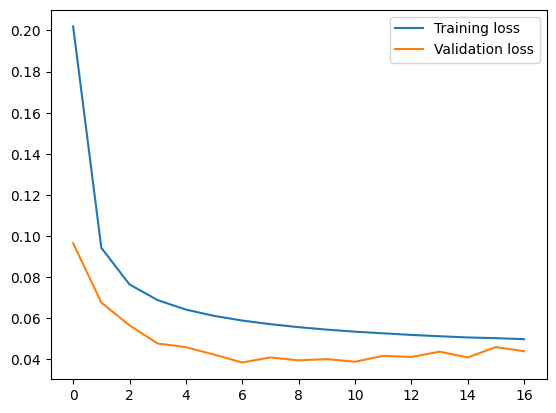

In [ ]:
plt.plot(history.history['loss'][1:], label='Training loss')
plt.plot(history.history['val_loss'][1:], label='Validation loss')
plt.legend() # increase learning rate to 10^-3


In [ ]:
model.save('LSTM_forecast_more_data_cut_correct_full_data2')

In [ ]:
print("done")

done


## new model end

In [ ]:
model = tf.keras.models.load_model('LSTM_forecast_more_data_cut_correct_full_data2')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 29, 512)           1079296   
                                                                 
 dropout (Dropout)           (None, 29, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 14)                3598      
                                                                 
Total params: 1870350 (7.13 MB)
Trainable params: 1870350 (7.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

63855/63855 [==============================] - 604s 9ms/step


In [ ]:
prediction.shape

(2043356, 14)

In [ ]:
np.array([testX[0]]).shape

(1, 29, 14)

In [ ]:
sample  = model.predict(np.array([testX[0]]))

1/1 [==============================] - 0s 64ms/step


In [ ]:
sample.shape

(1, 14)

In [ ]:
len(testSample[1])

14

In [ ]:
prediction.shape

(2043356, 14)

In [ ]:
out_data = [0]*14

In [ ]:
for scaleri in range(len(testSample[1])):
  scalerd = list(testSample[1].values())[scaleri]
  data = prediction[:,scaleri]
  data = data.reshape(data.shape[0],1)
  out_data[scaleri] = scalerd.inverse_transform(data)
  # out_data[scaleri] = scalerd.inverse_transform(data)

In [ ]:
testSample[1]

{'layerIndex': StandardScaler(),
 'Absolute process chamber humidity': StandardScaler(),
 'Building platform temperature': StandardScaler(),
 'Dosage factor': StandardScaler(),
 'Inertgas inlet valve': StandardScaler(),
 'Laser 1 temperature': StandardScaler(),
 'Oxygen concentration at top of process chamber': StandardScaler(),
 'Oxygen concentration in Recirculating filter system': StandardScaler(),
 'Process chamber temperature': StandardScaler(),
 'RFS filter pressure drop': StandardScaler(),
 'Recoater axis torque': StandardScaler(),
 'Relative ambient atmospheric humidity': StandardScaler(),
 'Room temperature': StandardScaler(),
 'Turbine pressure': StandardScaler()}

In [ ]:
out_data = np.array(out_data)
out_data.shape

(14, 2043356, 1)

In [ ]:
out_data = out_data.reshape(out_data.shape[0],out_data.shape[1])

In [ ]:
out_data = out_data.T

In [ ]:
out_data.shape

(2043356, 14)

In [ ]:
testY.shape

(2043356, 14)

In [ ]:
y_diff = np.abs(np.subtract(testY,prediction))

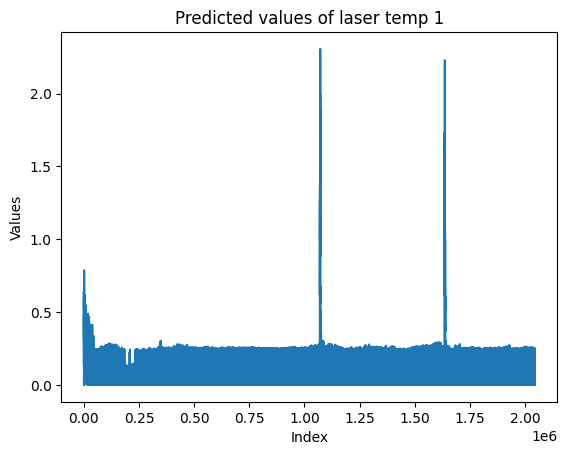

In [ ]:
plt.plot(y_diff[:,5])

# plt.ylim([23, 30])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted values of laser temp 1')

# Display the plot
plt.show()

In [ ]:
y_dif = np.zeros(y_pred_future.shape)
y_dif.shape

(1956107, 1)

In [ ]:
groundTruth = np.array(testSample[0]['Laser 1 temperature'].values)

In [ ]:
for i in range(len(y_pred_future)):
  y_dif[i] = prediction[i] - groundTruth[i]

In [ ]:
y_dif = np.abs(y_dif)

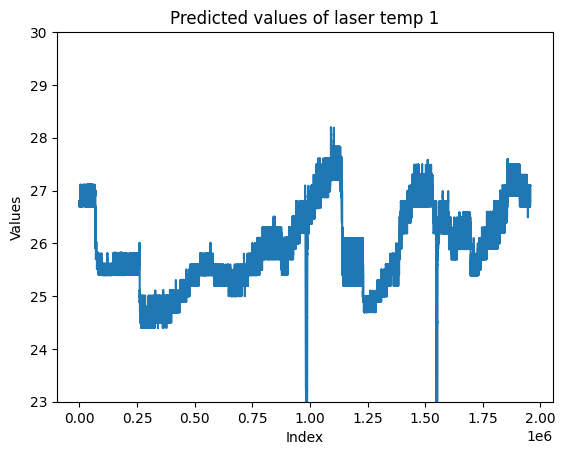

In [ ]:
plt.plot(y_pred_future)

plt.ylim([23, 30])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted values of laser temp 1')

# Display the plot
plt.show()

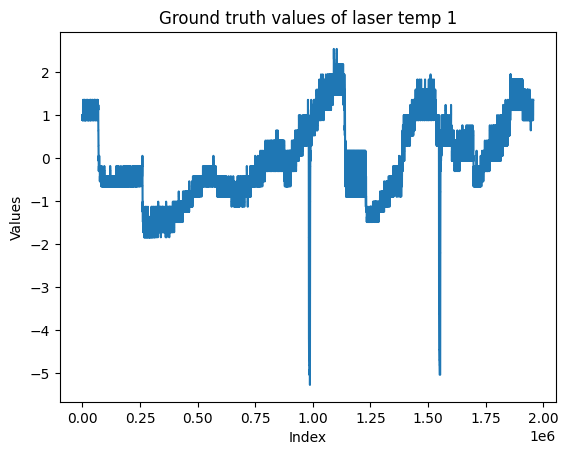

In [ ]:
plt.plot(groundTruth)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Ground truth values of laser temp 1')

# Display the plot
plt.show()

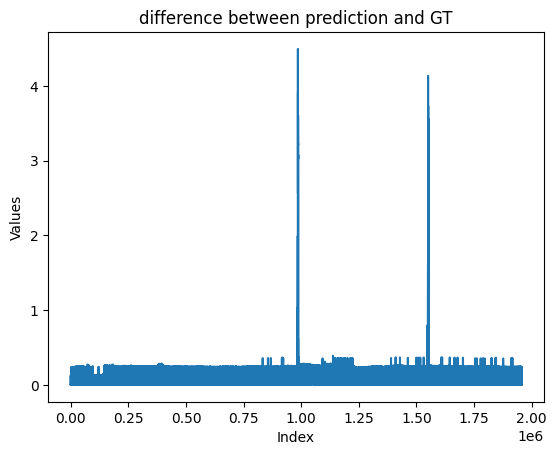

In [ ]:
plt.plot(y_dif)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('difference between prediction and GT')

# Display the plot
plt.show()

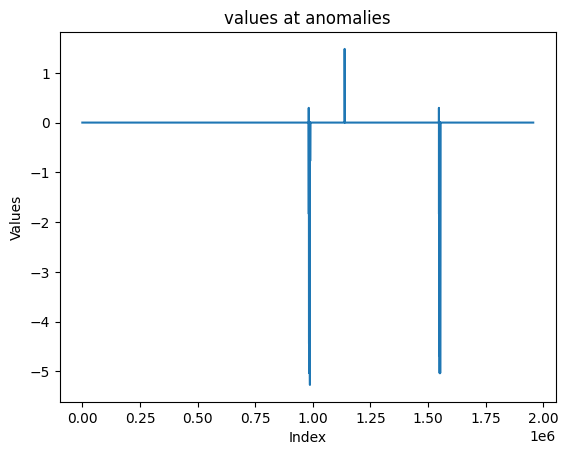

In [ ]:
y_threshold = [ testSample[0]['Laser 1 temperature'].values[i] if y >0.37 else 0 for i,y in enumerate(y_dif)]
plt.plot(y_threshold)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('values at anomalies')

# Display the plot
plt.show()

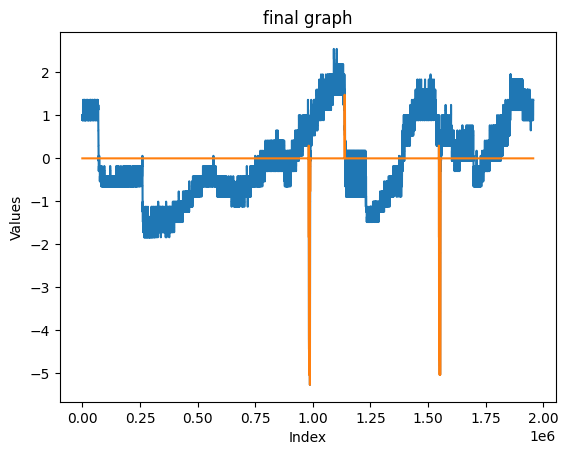

In [ ]:
plt.plot(testSample[0]['Laser 1 temperature'].values)
plt.plot(y_threshold)
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('final graph')

# Display the plot
plt.show()

# Single pont LSTM AutoEncoder


In [ ]:
list(preparedAllSamples.values())[0][0]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-76cd4aa9086e>", line 1, in <cell line: 1>
    list(preparedAllSamples.values())[0][0]
NameError: name 'preparedAllSamples' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/

In [ ]:
import random
import tensorflow as tf
window_size = 10

trainX=None
samples_count=1000000
currentCSV=1
conc =  pd.concat(list(preparedAllSamples.values())[:][0], axis=0)
# for dfc in list(preparedAllSamples.values()):
#   random_samples = random.sample(range(len(dfc[0])-window_size), samples_count)
#   data = dfc[0]
#   print('started CSV # :', currentCSV+1)
#   currentCSV = currentCSV + 1

#   if trainX == None:
#     trainX = [data.iloc[i] for i in range(len(data))]
#   else:
#     trainX += [data.iloc[i] for i in range(len(data))]

# X = np.array(trainX)
X = conc.values

In [ ]:
np.sum(np.isnan(X))

10583622

In [ ]:
X.shape

(12606126, 14)

In [ ]:
import tensorflow as tf

window_size=1

testInput = testSample[0]
testX = np.array([testInput.iloc[i] for i in range(len(testInput))])
# testX = testX[:,:,:14]

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns




In [ ]:
X.shape[1]

14

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(14,)))
BatchNormalization()
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu'))
BatchNormalization()
model.add(Dense(20, activation='relu'))
BatchNormalization()
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
BatchNormalization()
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(14))

model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 256)               3840      
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dense_45 (Dense)            (None, 20)                1300      
                                                                 
 dense_46 (Dense)            (None, 64)                1344      
                                                                 
 dropout_15 (Dropout)        (None, 64)              

In [ ]:
history = model.fit(X, X, epochs=20, batch_size=128, validation_split=0.1, verbose=1)

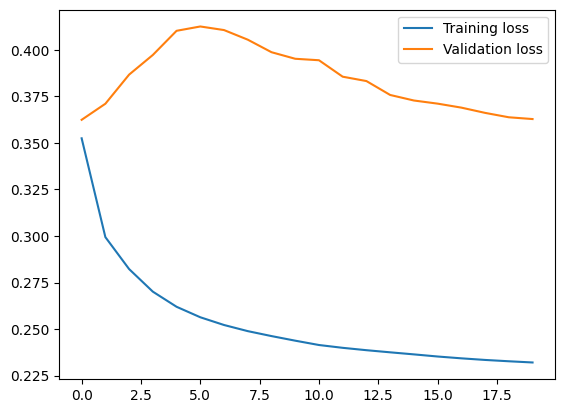

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
model.save('Point2Point_LSTM_Encoder_anomaly_mse')

In [ ]:
model = tf.keras.models.load_model('Point2Point_LSTM_Encoder_anomaly_mse')

In [ ]:
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

61130/61130 [==============================] - 91s 1ms/step


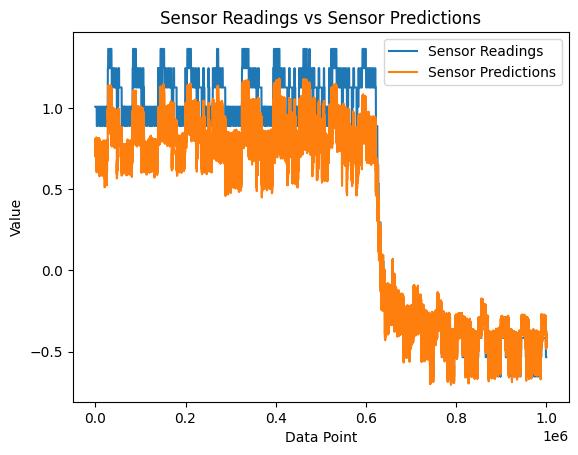

In [ ]:
import matplotlib.pyplot as plt
a = testX.reshape((1956127*9, 14))
b = prediction.reshape(1956127*9,14)
a1 = a[:,5][:1000000]
b1= b[:,5][:1000000]
plt.plot(a1, label='Sensor Readings')
plt.plot(b1, label='Sensor Predictions')

plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Sensor Readings vs Sensor Predictions')
plt.legend()

plt.show()


## Sequence to Sequence LSTM AutoEncoder evaluation and anomaly detection with thresholding


### the actual evaluation with absolute difference and l2 norm between reconstruction and data for comparison

## using L2 norm between prediction and target

In [ ]:
l2_norm = np.linalg.norm(prediction - testX, axis=(1))


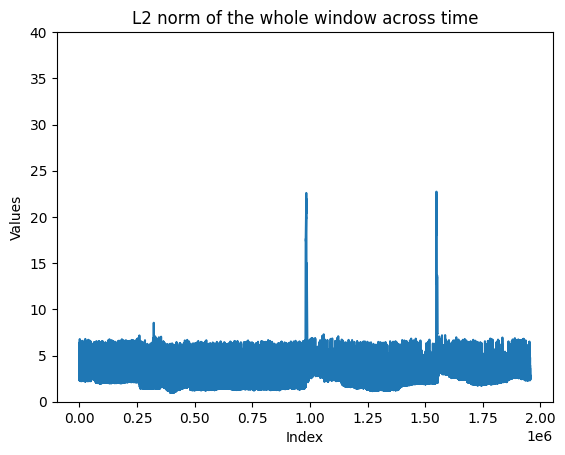

In [ ]:
plt.plot(l2_norm)

plt.ylim([0, 40])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('L2 norm of the whole window across time')

# Display the plot
plt.show()

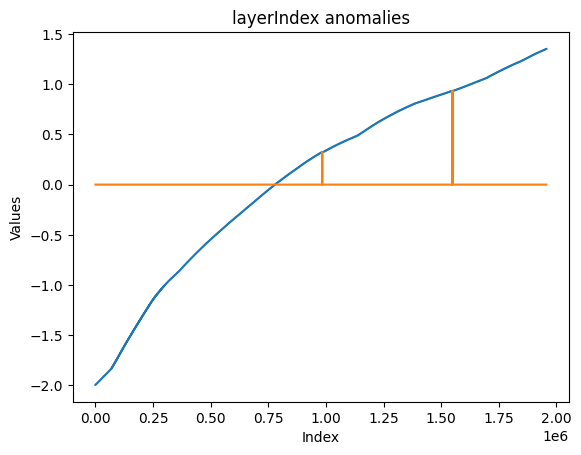

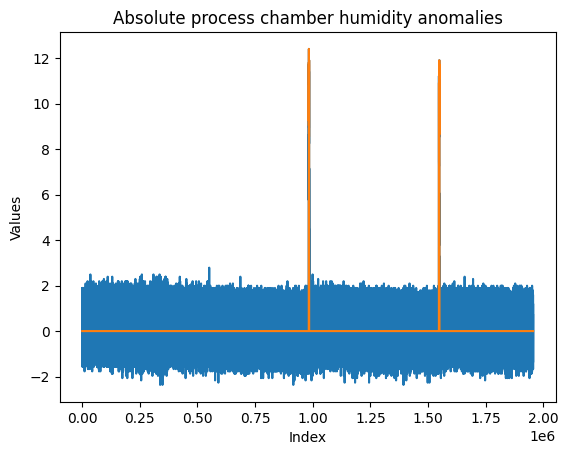

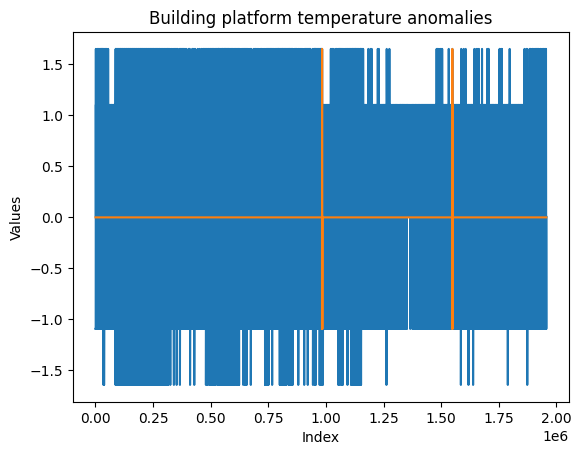

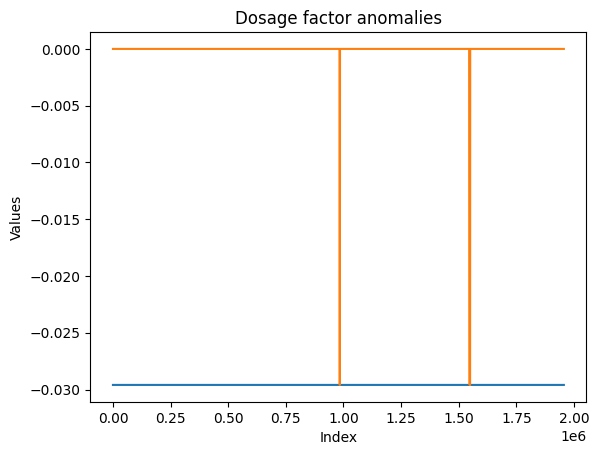

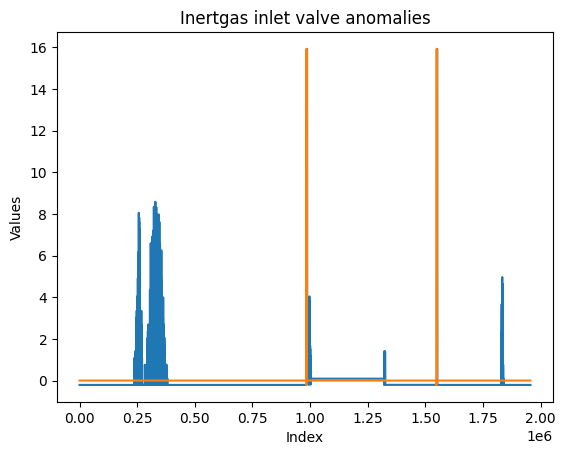

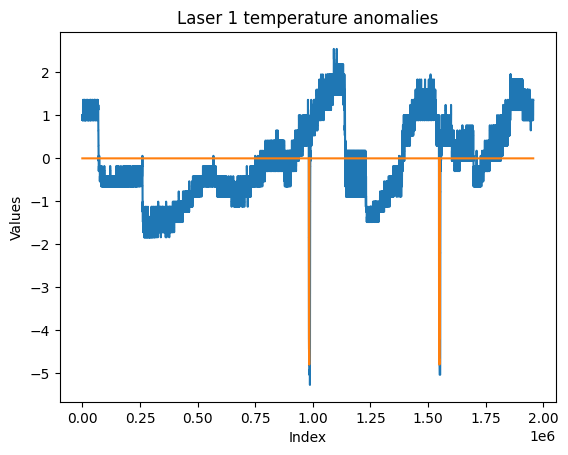

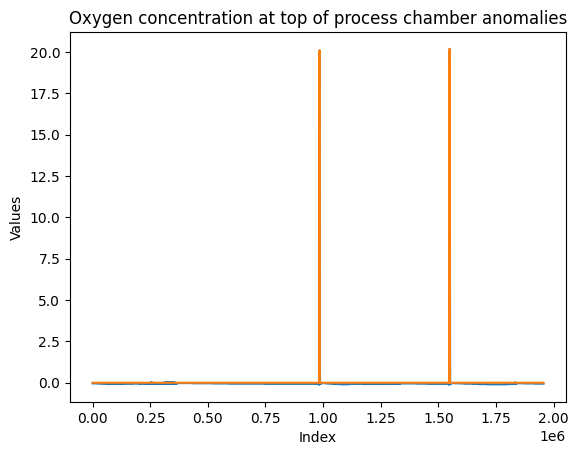

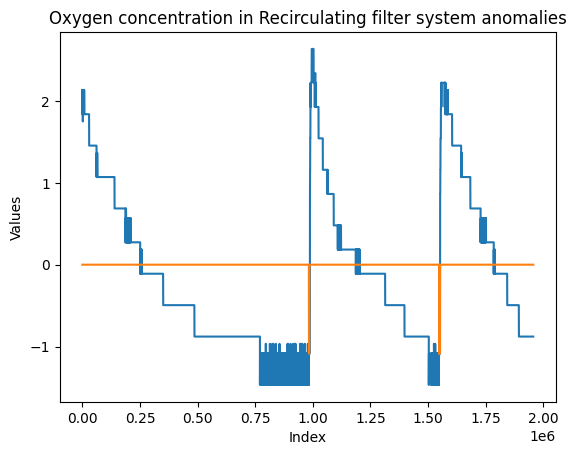

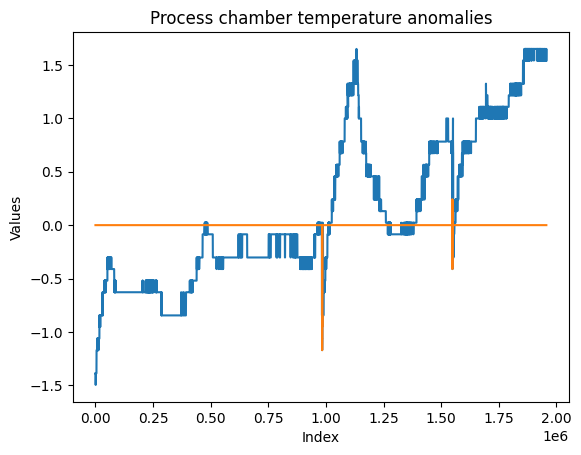

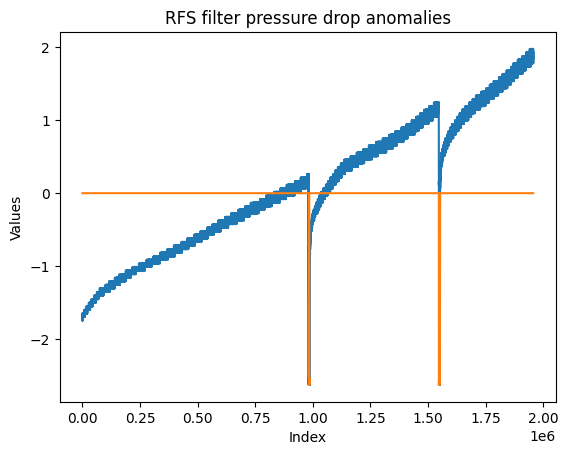

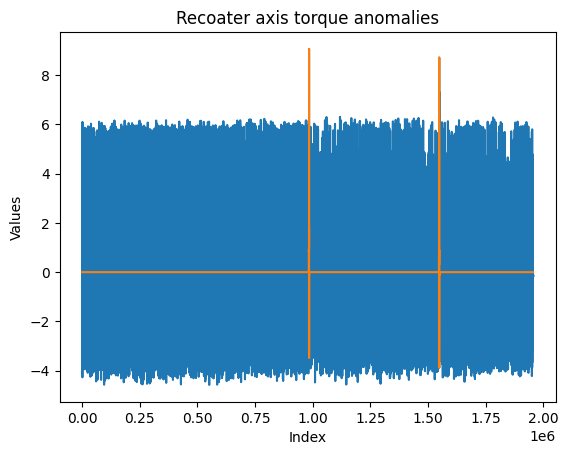

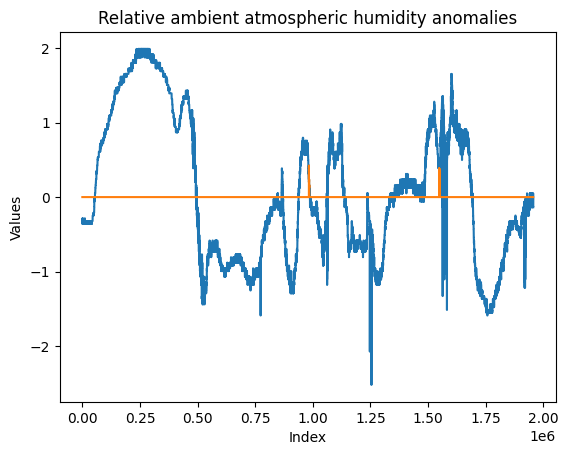

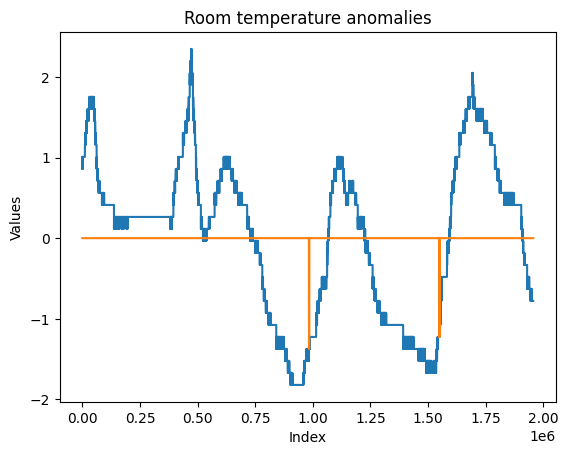

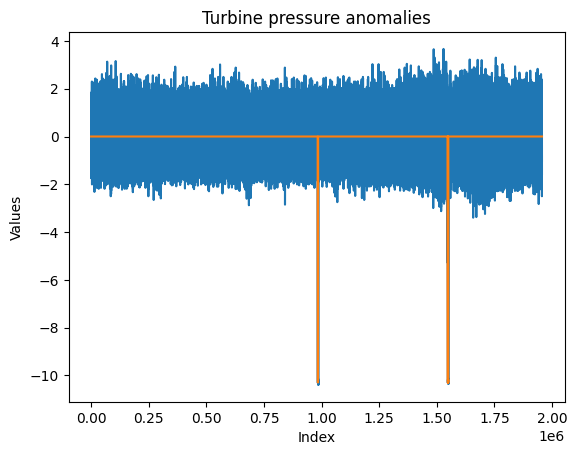

In [ ]:
for sensorName in targetName:
  y_threshold = [ testSample[0][sensorName].values[i+5] if y >20 else 0 for i,y in enumerate(l2_norm)]

  plt.plot(testSample[0][sensorName].values)
  plt.plot(y_threshold)
  # Adding labels and title
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title(sensorName+' anomalies')

  # Display the plot
  plt.show()

## using L1 mean absolute difference

In [ ]:
l1_norm = np.mean(np.abs(prediction - testX), axis=(1))

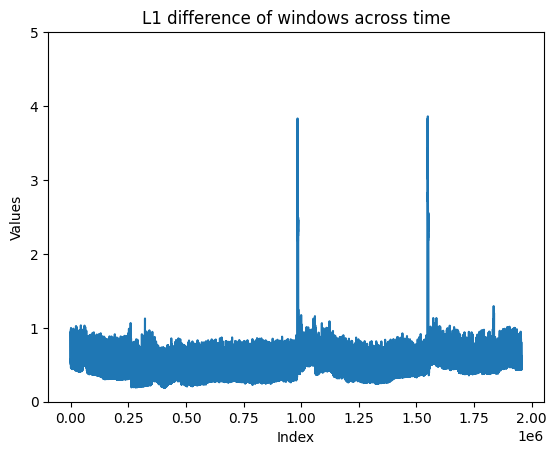

In [ ]:
plt.plot(l1_norm)

plt.ylim([0, 5])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('L1 difference of windows across time')

# Display the plot
plt.show()

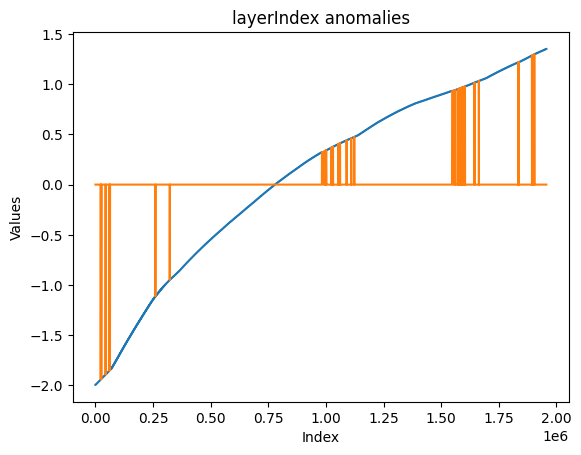

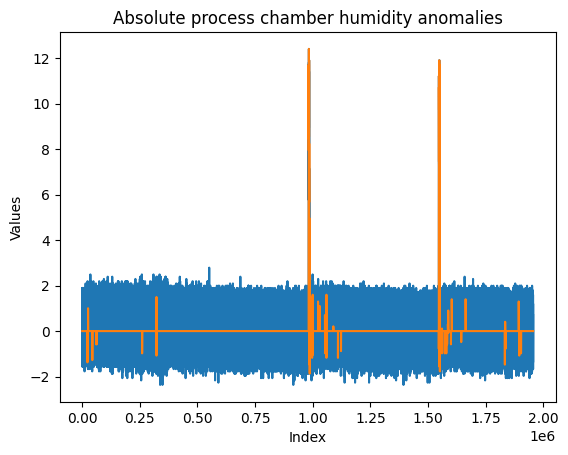

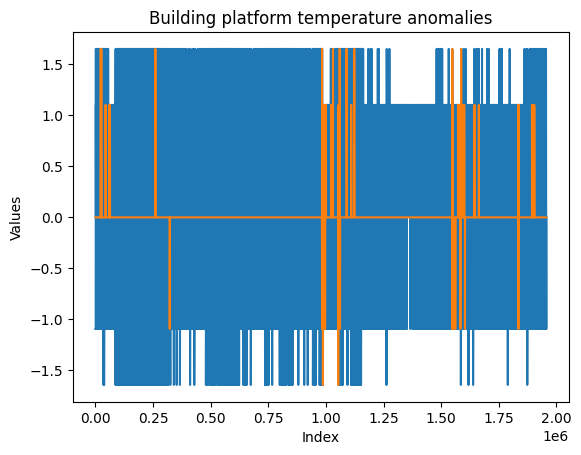

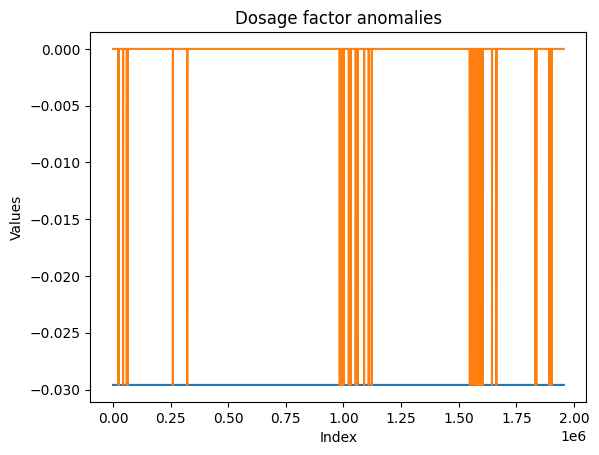

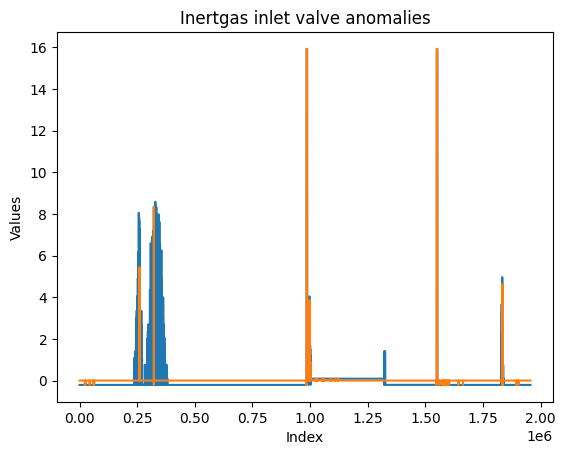

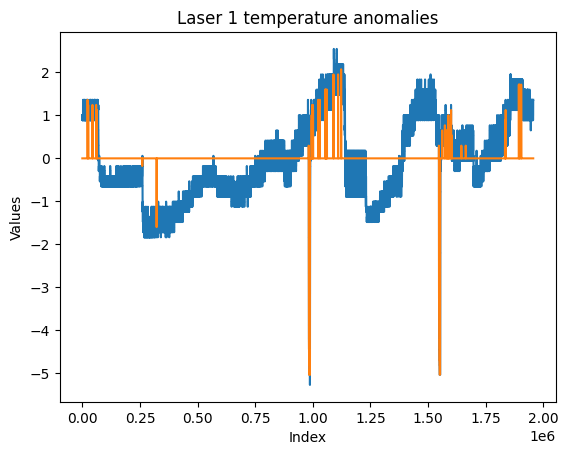

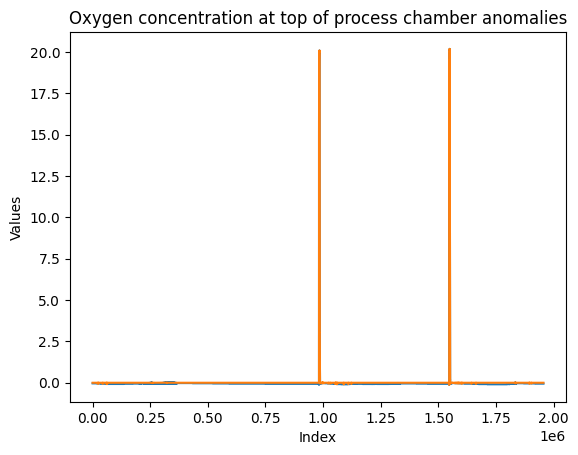

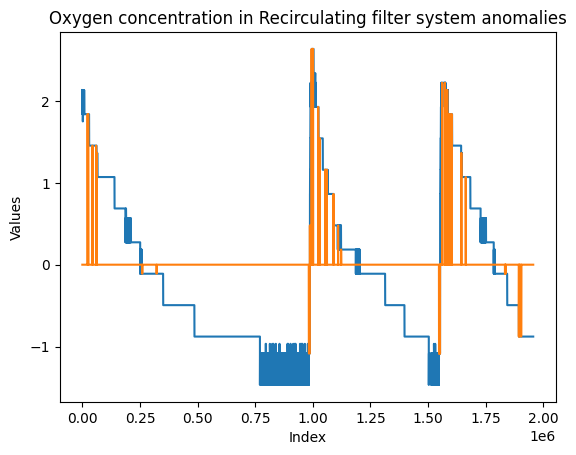

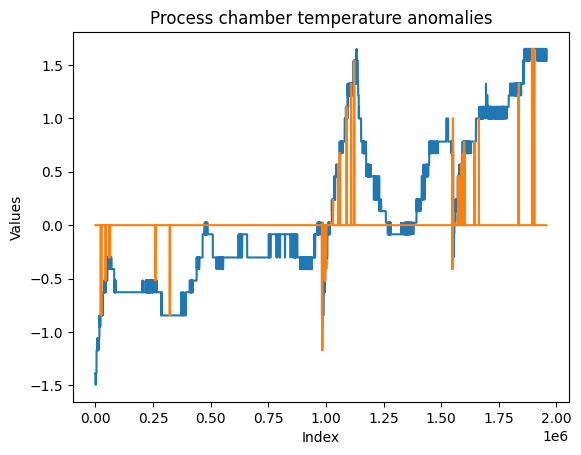

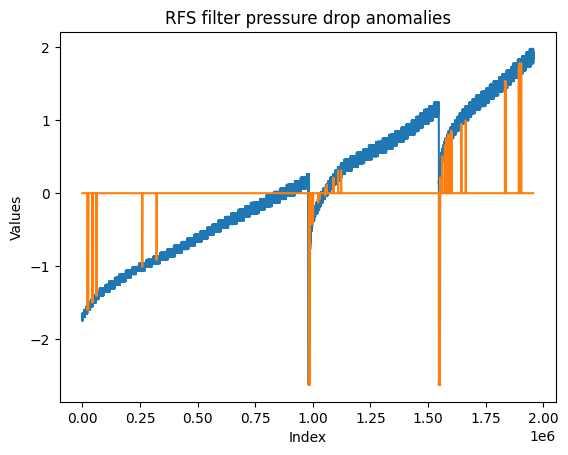

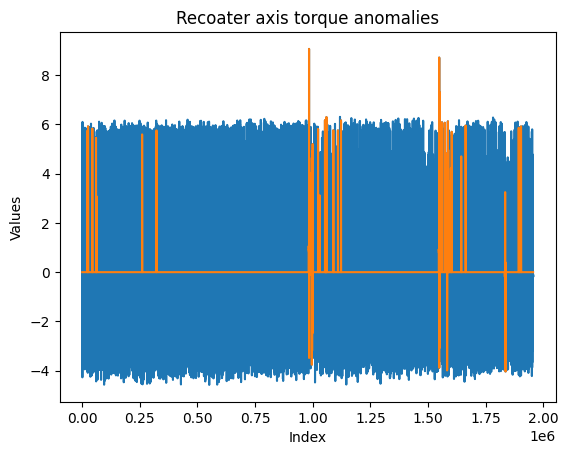

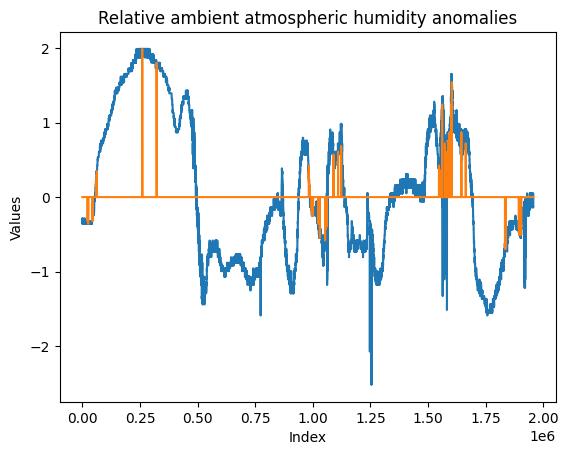

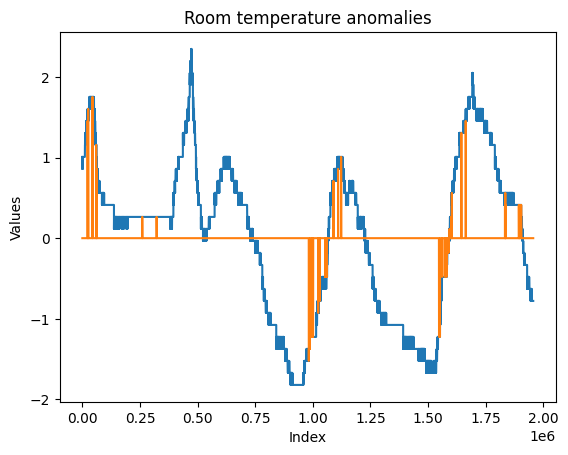

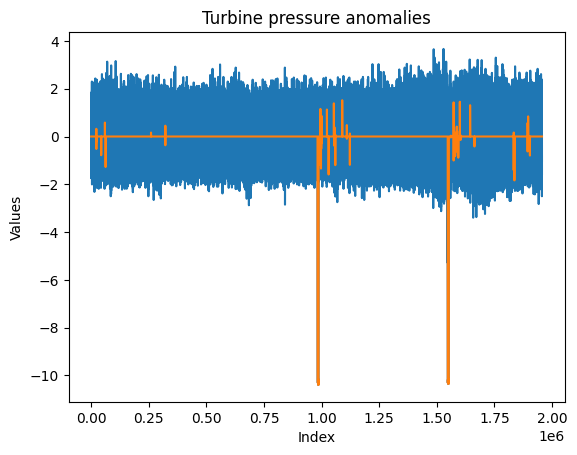

In [ ]:
for sensorName in targetName:
  y_threshold = [ testSample[0][sensorName].values[i+5] if y >1 else 0 for i,y in enumerate(l1_norm)]

  plt.plot(testSample[0][sensorName].values)
  plt.plot(y_threshold)

  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title(sensorName+' anomalies')

  plt.show()

# seq2Seq(window) Variational AutoEncoder

### A better variant of the regular autoencoder that does sampling from a distribtion that is calculated from the input at the latent space and uses it for fitting the model and calculating the loss, it generally performs better and from what can be seen here it detected better maybe-anomaly areas

In [ ]:
from tensorflow.keras import callbacks

In [ ]:
model_checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',  # You can use 'loss' if you don't have validation data
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # You can use 'loss' if you don't have validation data
    patience=10,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

global z_mean
global z_log_var

# Define the LSTM-based VAE model for predicting the whole window
class LSTMVaeWindowPredictor(keras.Model):
    def __init__(self, latent_dim, window_size):
        super(LSTMVaeWindowPredictor, self).__init__()
        self.latent_dim = latent_dim
        self.window_size = window_size
        self.m = [1] * latent_dim
        self.s = [1] * latent_dim
        # Encoder
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(window_size, input_dim)),
            layers.LSTM(128, activation='relu', return_sequences=True),
            layers.LSTM(64, activation='relu'),
            layers.Dense(latent_dim * 2)  # Use twice the latent_dim for mean and log variance
        ])

        # Decoder
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.RepeatVector(window_size),
            layers.LSTM(64, activation='relu', return_sequences=True),
            layers.LSTM(128, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output layer activation depends on data type
        ])

    def encode(self, x):
        z_mean, z_log_var = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
      target = self.encode(x)
      self.m = target[0]
      self.s = target[1]
      z = self.reparameterize(self.m, self.s)
      x_reconstructed = self.decode(z)
      return x_reconstructed

    def lstm_vae_loss(self, y_true, y_pred):
      x_reconstructed = y_pred

      # Extract the true input (x) and predicted output (x_reconstructed)
      x = tf.reshape(y_true, (-1, input_dim * window_size))
      x_reconstructed = tf.reshape(x_reconstructed, (-1, input_dim * window_size))

      # Reconstruction loss
      reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_reconstructed))

      # KL divergence loss
      kl_loss = -0.5 * tf.reduce_sum(1 + self.s - tf.square(self.m) - tf.exp(self.s), axis=-1)

      return reconstruction_loss + kl_loss
# Create an instance of the LSTMVaeWindowPredictor model
latent_dim = 20  # Set the size of the latent space
window_size = 9  # Set the size of the input window
input_dim = 14  # Adjust based on your input dimensionality
lstm_vae_window_predictor = LSTMVaeWindowPredictor(latent_dim, window_size)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)
lstm_vae_window_predictor.compile(optimizer=optimizer, loss=lstm_vae_window_predictor.lstm_vae_loss)

In [ ]:
history = lstm_vae_window_predictor.fit(X, X, epochs=5, batch_size=264, validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/5
20455/20455 [==============================] - 984s 48ms/step - loss: -2.1739 - val_loss: -1.3849
Epoch 2/5
20455/20455 [==============================] - 971s 47ms/step - loss: -2.3175 - val_loss: -1.3770
Epoch 3/5
20455/20455 [==============================] - 978s 48ms/step - loss: -2.3230 - val_loss: -1.3840
Epoch 4/5
20455/20455 [==============================] - 975s 48ms/step - loss: -2.3257 - val_loss: -1.3726
Epoch 5/5
20455/20455 [==============================] - 975s 48ms/step - loss: -2.3270 - val_loss: -1.3628


In [ ]:
lstm_vae_window_predictor.save('LSTM_VAE_Seq2Seq_big_allCSVs')

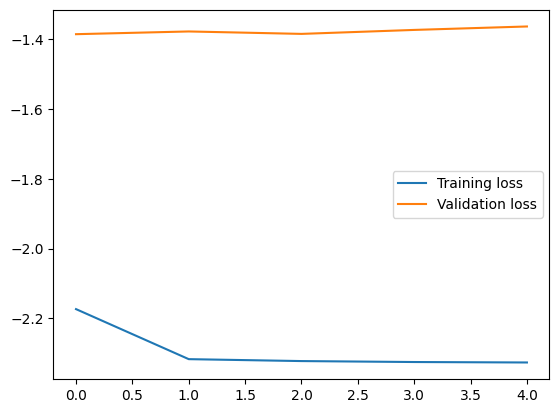

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
import tensorflow as tf
custom_objects = {'lstm_vae_loss': lstm_vae_window_predictor.lstm_vae_loss}
lstm_vae_window_predictor = tf.keras.models.load_model('LSTM_VAE_Seq2Seq_big_allCSVs', custom_objects=custom_objects)

In [ ]:
window_size=9

testInput = testSample[0]
testX = np.array([testInput[i:i+window_size].values for i in range(len(testInput)-window_size)])

In [ ]:
testX = testX[:,:,:14]

In [ ]:
prediction = lstm_vae_window_predictor.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

61129/61129 [==============================] - 510s 8ms/step


In [ ]:
l2_norm = np.linalg.norm(prediction - testX, axis=(1, 2))


In [ ]:
testX.shape

(1956127, 9, 14)

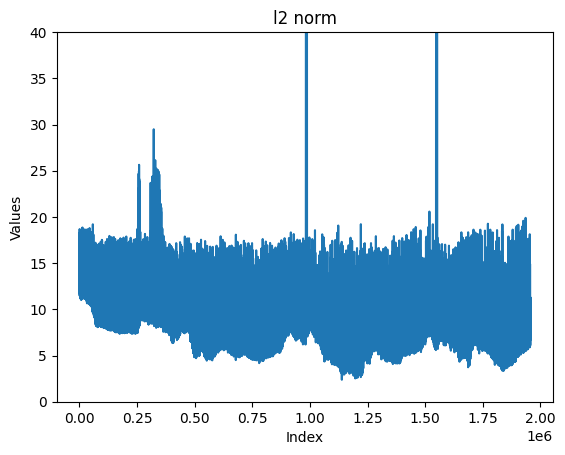

In [ ]:
plt.plot(l2_norm)

plt.ylim([0, 40])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('l2 norm')

# Display the plot
plt.show()

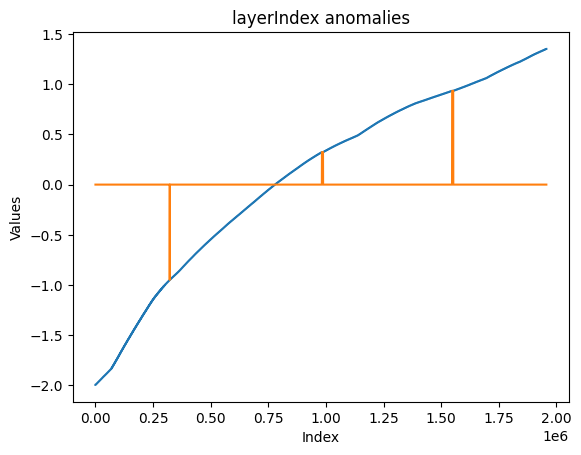

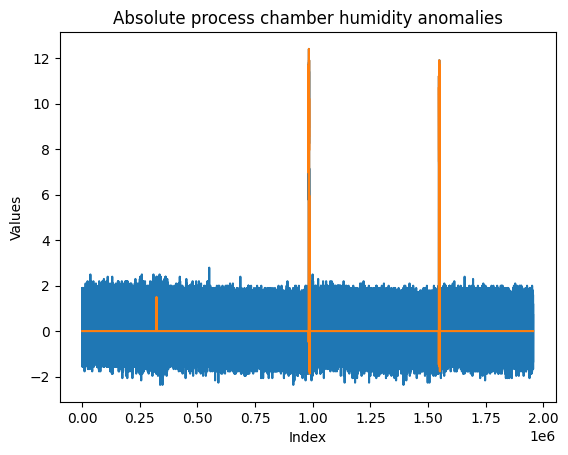

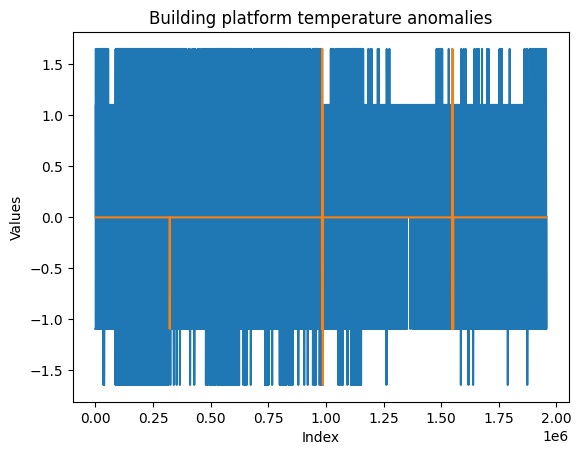

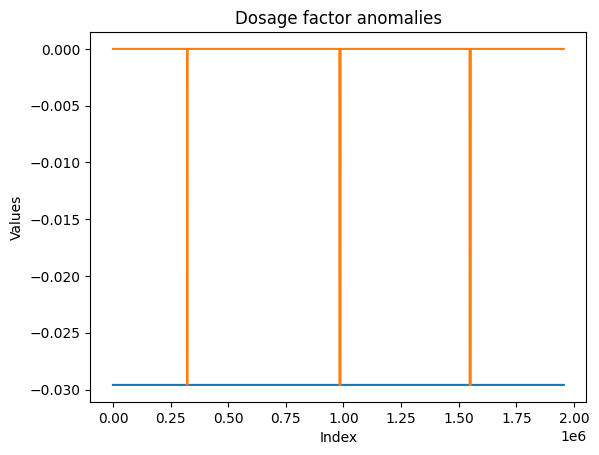

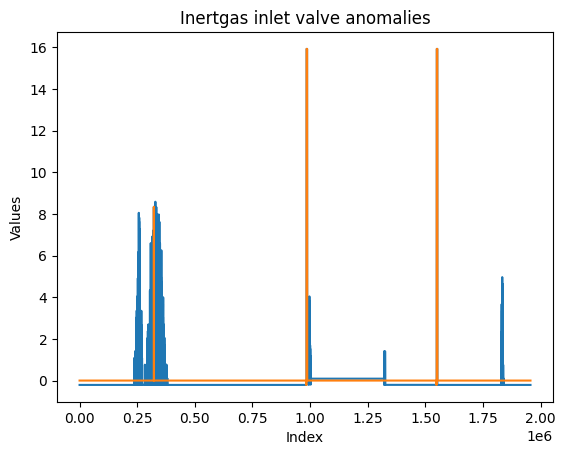

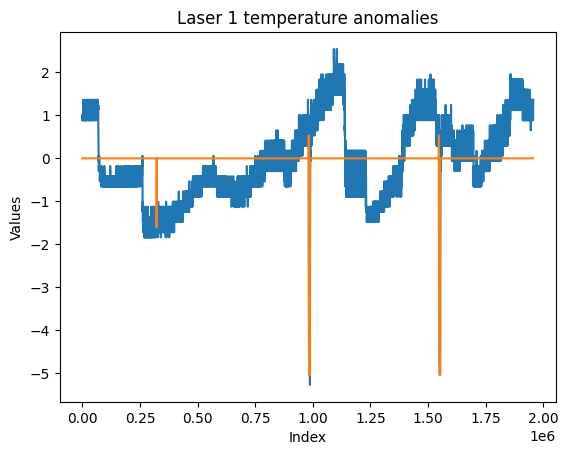

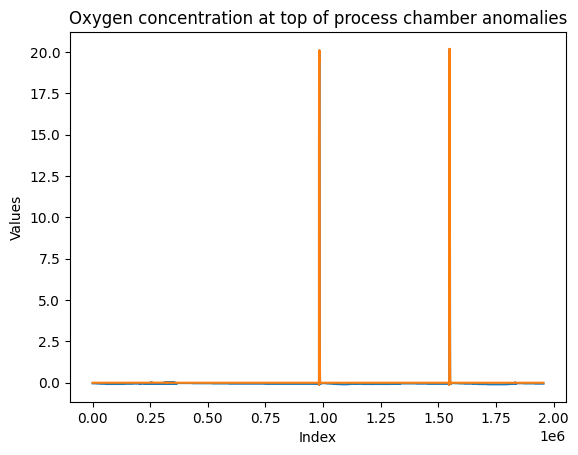

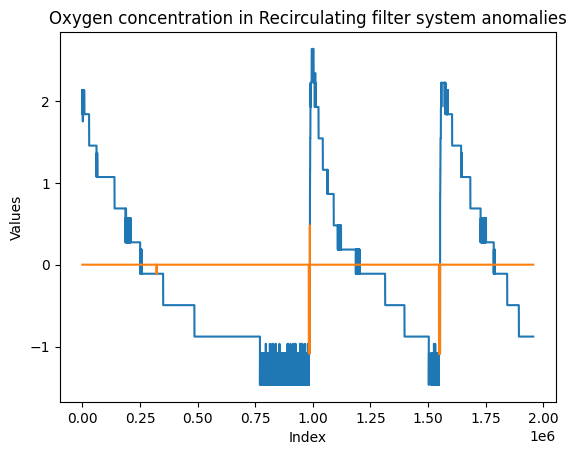

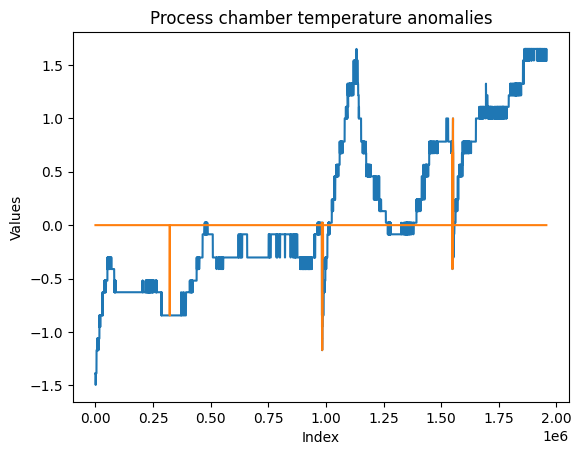

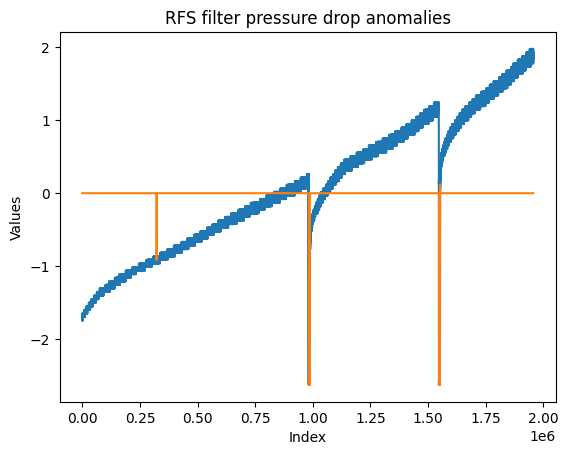

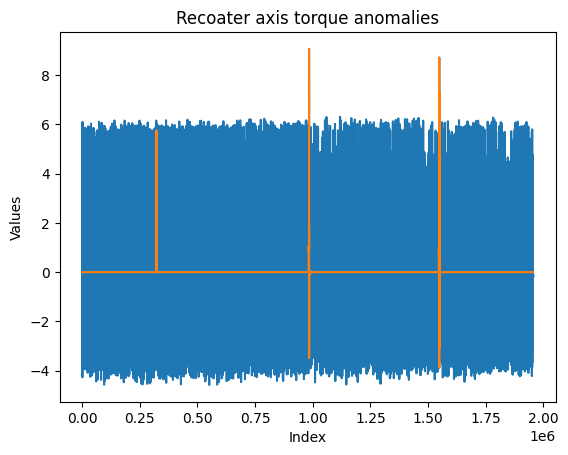

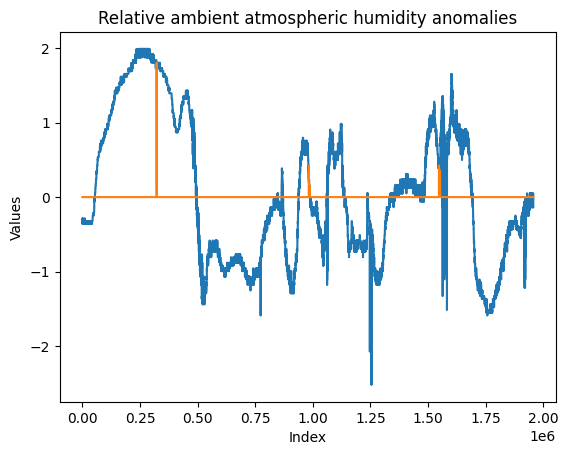

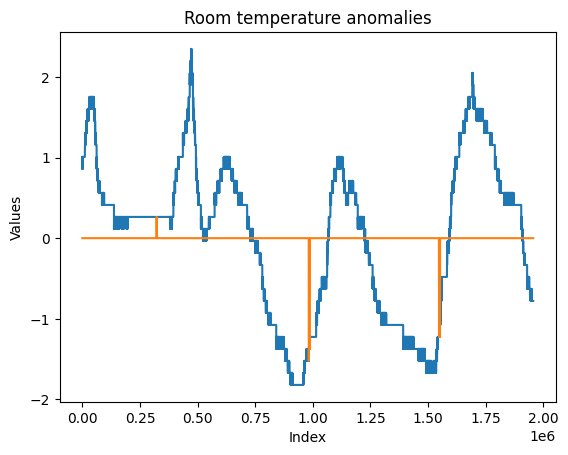

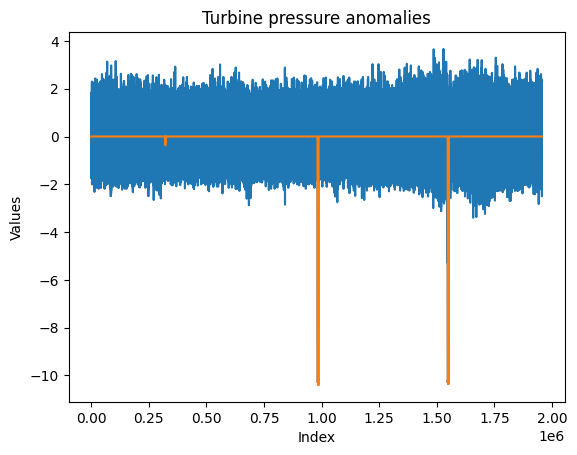

In [ ]:
for sensorName in targetName:
  y_threshold = [ testSample[0][sensorName].values[i+5] if y >27 else 0 for i,y in enumerate(l2_norm)]


  plt.plot(testSample[0][sensorName].values)
  plt.plot(y_threshold)
  # Adding labels and title
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title(sensorName+' anomalies')

  # Display the plot
  plt.show()

# Single Point VAE

In [ ]:
from tensorflow.keras import callbacks

In [ ]:
import random
import tensorflow as tf

trainX=np.empty((0, 14))
currentCSV=1
for dfc in list(preparedAllSamples.values()):
  # random_samples = random.sample(range(len(dfc[0])-window_size), samples_count)
  data = dfc[0]
  print('started CSV # :', currentCSV+1)
  currentCSV = currentCSV + 1
  print(len(data))
  trainX = np.concatenate((trainX, np.array(data)))
X = trainX

started CSV # : 2
2207274
started CSV # : 3
2189779
started CSV # : 4
2172525
started CSV # : 5
2217893
started CSV # : 6
2280126
started CSV # : 7
1538529


In [ ]:
np.sum(np.isnan(X))

0

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # You can use 'loss' if you don't have validation data
    patience=10,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

global z_mean
global z_log_var

# Define the LSTM-based VAE model for predicting the whole window
class LSTMVaeWindowPredictor(keras.Model):
    def __init__(self, latent_dim):
        super(LSTMVaeWindowPredictor, self).__init__()
        self.latent_dim = latent_dim
        self.m = [1] * latent_dim
        self.s = [1] * latent_dim
        # Encoder
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=input_dim),
            layers.Dense(128, activation='LeakyReLU'),
            layers.Dense(64, activation='LeakyReLU'),
            layers.Dense(latent_dim * 2)  # Use twice the latent_dim for mean and log variance
        ])

        # Decoder
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='LeakyReLU'),
            layers.Dense(128, activation='LeakyReLU'),
            layers.Dense(input_dim, activation='sigmoid')  # Output layer activation depends on data type
        ])

    def encode(self, x):
        z_mean, z_log_var = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
      target = self.encode(x)
      self.m = target[0]
      self.s = target[1]
      z = self.reparameterize(self.m, self.s)
      x_reconstructed = self.decode(z)
      return x_reconstructed

    def lstm_vae_loss(self, y_true, y_pred):
      x_reconstructed = y_pred

      # Extract the true input (x) and predicted output (x_reconstructed)
      x = tf.reshape(y_true, (-1, input_dim))
      x_reconstructed = tf.reshape(x_reconstructed, (-1, input_dim))

      # Reconstruction loss
      reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_reconstructed))

      # KL divergence loss
      kl_loss = -0.5 * tf.reduce_sum(1 + self.s - tf.square(self.m) - tf.exp(self.s), axis=-1)

      return reconstruction_loss + kl_loss
# Create an instance of the LSTMVaeWindowPredictor model
latent_dim = 20  # Set the size of the latent space
input_dim = 14  # Adjust based on your input dimensionality
lstm_vae_window_predictor = LSTMVaeWindowPredictor(latent_dim)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.00004, clipnorm=1.0)
lstm_vae_window_predictor.compile(optimizer=optimizer, loss=lstm_vae_window_predictor.lstm_vae_loss)

In [ ]:
history = lstm_vae_window_predictor.fit(X, X, epochs=5, batch_size=128, validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/5
88637/88637 [==============================] - 461s 5ms/step - loss: -2.2176 - val_loss: -1.1775
Epoch 2/5
88637/88637 [==============================] - 454s 5ms/step - loss: -2.5201 - val_loss: -1.2811
Epoch 3/5
88637/88637 [==============================] - 450s 5ms/step - loss: -2.5504 - val_loss: -1.2764
Epoch 4/5
88637/88637 [==============================] - 454s 5ms/step - loss: -2.5630 - val_loss: -1.3639
Epoch 5/5
88637/88637 [==============================] - 454s 5ms/step - loss: -2.5732 - val_loss: -1.4116


In [ ]:
lstm_vae_window_predictor.save('LSTM_VAE_SinglePoint_big_allCSVs_chk3')

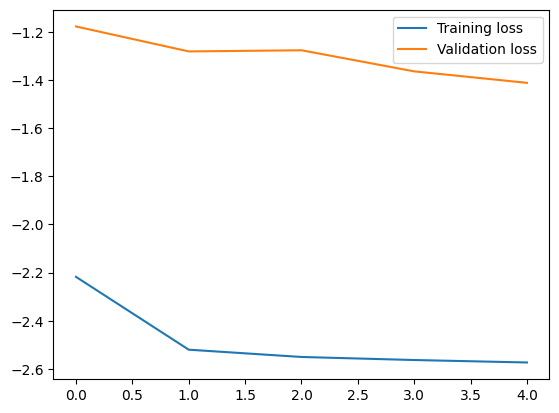

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
import tensorflow as tf
custom_objects = {'lstm_vae_loss': lstm_vae_window_predictor.lstm_vae_loss}
lstm_vae_window_predictor = tf.keras.models.load_model('LSTM_VAE_SinglePoint_big_allCSVs_chk3', custom_objects=custom_objects)

In [ ]:
testX = testSample[0]
testX

layerIndex  Absolute process chamber humidity  \
87249     -1.995036                           1.202342   
87250     -1.995036                           1.202342   
87251     -1.995036                           1.202342   
87252     -1.995036                           0.210756   
87253     -1.995036                           0.210756   
...             ...                                ...   
2043380    1.351290                           0.706549   
2043381    1.351290                           0.706549   
2043382    1.351290                           0.706549   
2043383    1.351290                           0.706549   
2043384    1.351290                           0.706549   

         Building platform temperature  Dosage factor  Inertgas inlet valve  \
87249                        -1.094138      -0.029593             -0.209399   
87250                        -1.094138      -0.029593             -0.209399   
87251                        -1.094138      -0.029593             -0.209399   
87252                        -1.094138      -0.029593             -0.209399   
87253                        -1.094138      -0.029593             -0.209399   
...                                ...            ...                   ...   
2043380                       0.004423      -0.029593             -0.209399   
2043381                       0.004423      -0.029593             -0.209399   
2043382                       0.004423      -0.029593             -0.209399   
2043383                       0.004423      -0.029593             -0.209399   
2043384                       0.004423      -0.029593             -0.209399   

         Laser 1 temperature  Oxygen concentration at top of process chamber  \
87249               1.006955                                       -0.039107   
87250               1.006955                                       -0.039107   
87251               1.006955                                       -0.039107   
87252               1.006955                                       -0.039107   
87253               1.006955                                       -0.039107   
...                      ...                                             ...   
2043380             1.362519                                       -0.055697   
2043381             1.362519                                       -0.055697   
2043382             1.362519                                       -0.055697   
2043383             1.362519                                       -0.055697   
2043384             1.362519                                       -0.055697   

         Oxygen concentration in Recirculating filter system  \
87249                                             2.134003     
87250                                             2.134003     
87251                                             2.134003     
87252                                             2.134003     
87253                                             2.134003     
...                                                    ...     
2043380                                          -0.878226     
2043381                                          -0.878226     
2043382                                          -0.878226     
2043383                                          -0.878226     
2043384                                          -0.878226     

         Process chamber temperature  RFS filter pressure drop  \
87249                      -1.386480                 -1.693586   
87250                      -1.386480                 -1.693586   
87251                      -1.386480                 -1.693586   
87252                      -1.386480                 -1.693586   
87253                      -1.386480                 -1.693586   
...                              ...                       ...   
2043380                     1.540269                  1.924672   
2043381                     1.540269                  1.924672   
2043382                     1.540269   

In [ ]:
testX = testX[:][:14]

In [ ]:
testX.shape

(1956136, 14)

In [ ]:
prediction = lstm_vae_window_predictor.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

61130/61130 [==============================] - 95s 2ms/step


In [ ]:
testX

layerIndex  Absolute process chamber humidity  \
87249     -1.995036                           1.202342   
87250     -1.995036                           1.202342   
87251     -1.995036                           1.202342   
87252     -1.995036                           0.210756   
87253     -1.995036                           0.210756   
...             ...                                ...   
2043380    1.351290                           0.706549   
2043381    1.351290                           0.706549   
2043382    1.351290                           0.706549   
2043383    1.351290                           0.706549   
2043384    1.351290                           0.706549   

         Building platform temperature  Dosage factor  Inertgas inlet valve  \
87249                        -1.094138      -0.029593             -0.209399   
87250                        -1.094138      -0.029593             -0.209399   
87251                        -1.094138      -0.029593             -0.209399   
87252                        -1.094138      -0.029593             -0.209399   
87253                        -1.094138      -0.029593             -0.209399   
...                                ...            ...                   ...   
2043380                       0.004423      -0.029593             -0.209399   
2043381                       0.004423      -0.029593             -0.209399   
2043382                       0.004423      -0.029593             -0.209399   
2043383                       0.004423      -0.029593             -0.209399   
2043384                       0.004423      -0.029593             -0.209399   

         Laser 1 temperature  Oxygen concentration at top of process chamber  \
87249               1.006955                                       -0.039107   
87250               1.006955                                       -0.039107   
87251               1.006955                                       -0.039107   
87252               1.006955                                       -0.039107   
87253               1.006955                                       -0.039107   
...                      ...                                             ...   
2043380             1.362519                                       -0.055697   
2043381             1.362519                                       -0.055697   
2043382             1.362519                                       -0.055697   
2043383             1.362519                                       -0.055697   
2043384             1.362519                                       -0.055697   

         Oxygen concentration in Recirculating filter system  \
87249                                             2.134003     
87250                                             2.134003     
87251                                             2.134003     
87252                                             2.134003     
87253                                             2.134003     
...                                                    ...     
2043380                                          -0.878226     
2043381                                          -0.878226     
2043382                                          -0.878226     
2043383                                          -0.878226     
2043384                                          -0.878226     

         Process chamber temperature  RFS filter pressure drop  \
87249                      -1.386480                 -1.693586   
87250                      -1.386480                 -1.693586   
87251                      -1.386480                 -1.693586   
87252                      -1.386480                 -1.693586   
87253                      -1.386480                 -1.693586   
...                              ...                       ...   
2043380                     1.540269                  1.924672   
2043381                     1.540269                  1.924672   
2043382                     1.540269   

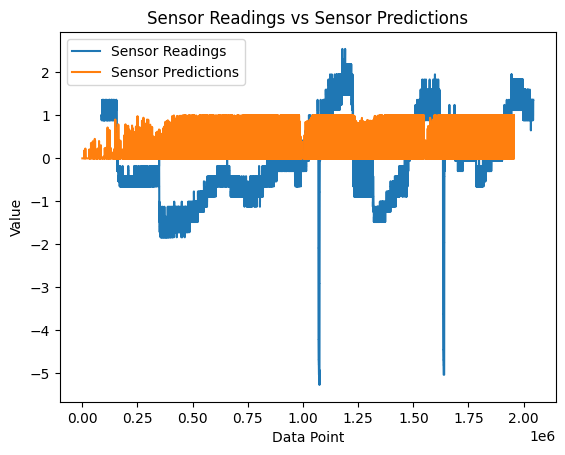

In [ ]:
import matplotlib.pyplot as plt
a =testX[:]['Laser 1 temperature']
b =prediction[:,5]
plt.plot(a, label='Sensor Readings')
plt.plot(b, label='Sensor Predictions')

plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Sensor Readings vs Sensor Predictions')
plt.legend()

plt.show()


In [ ]:
l2_norm = np.linalg.norm(prediction - testX, axis=(1))


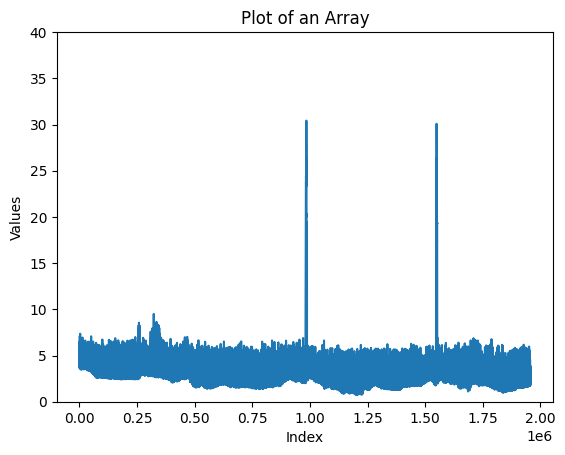

In [ ]:
plt.plot(l2_norm)

plt.ylim([0, 40])
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of an Array')

# Display the plot
plt.show()

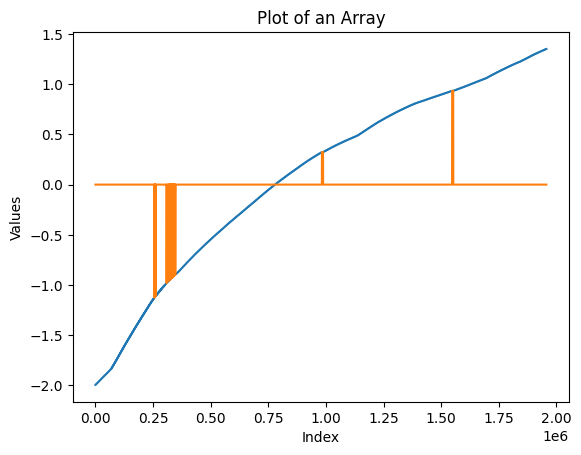

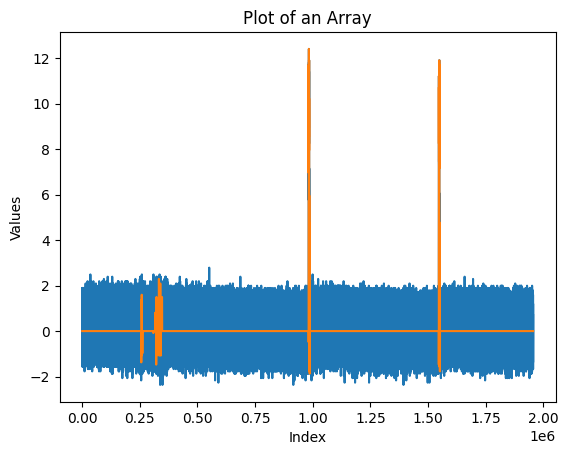

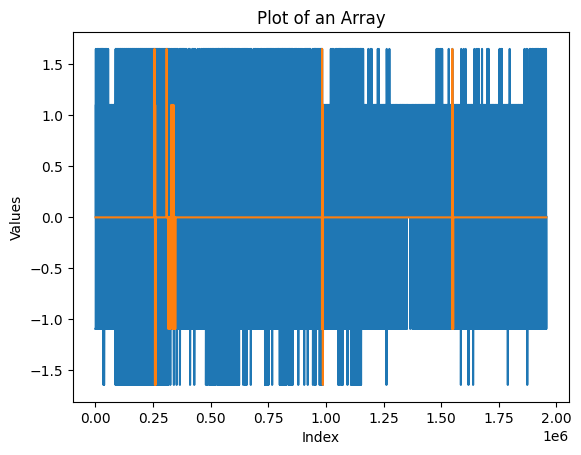

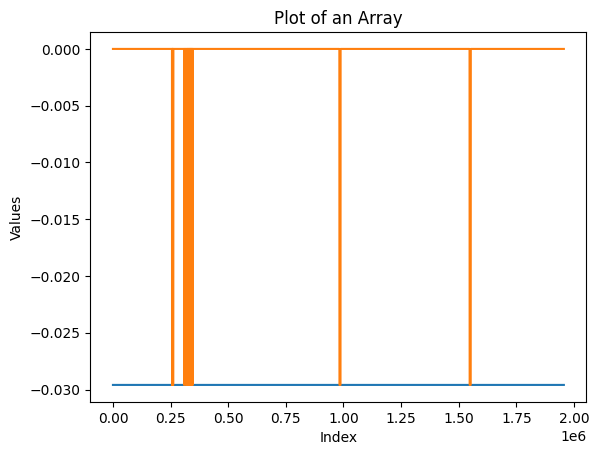

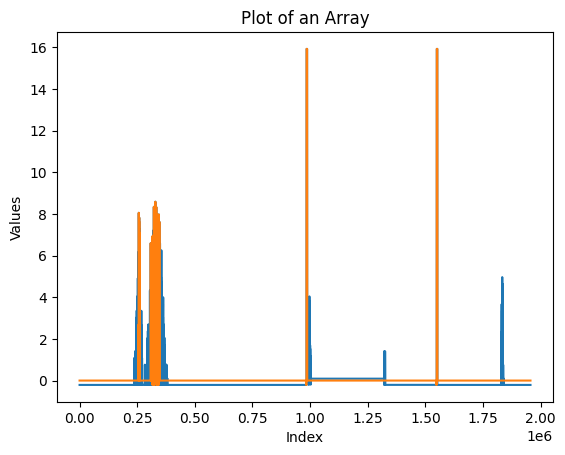

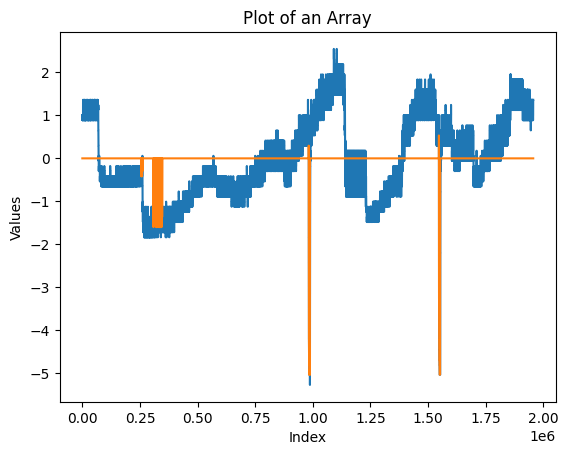

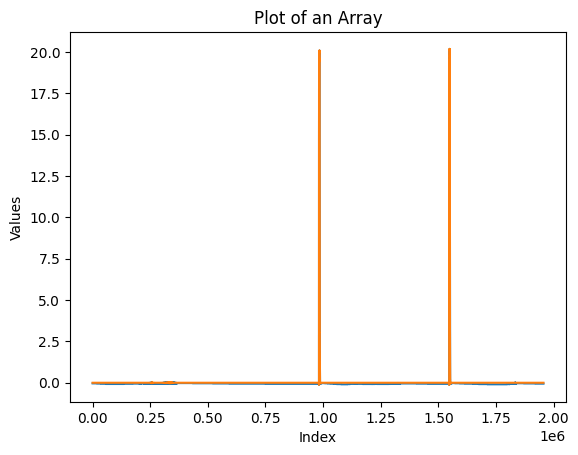

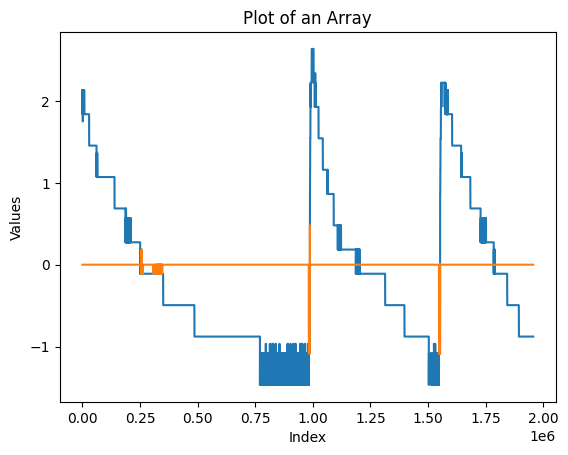

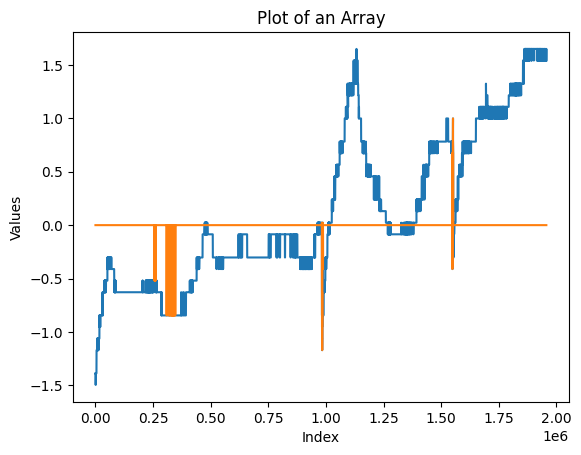

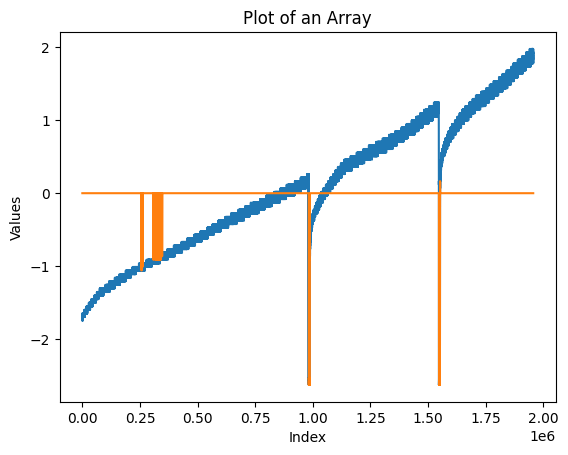

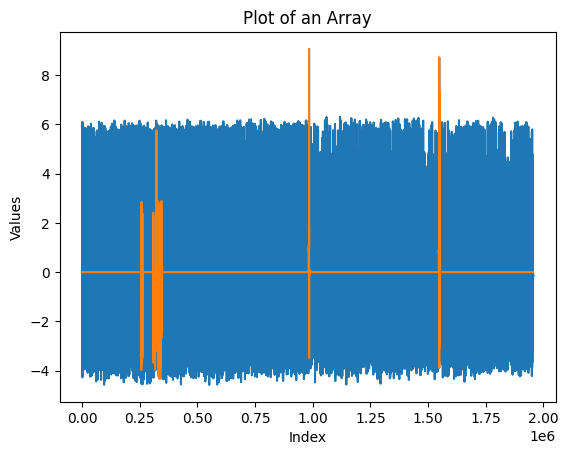

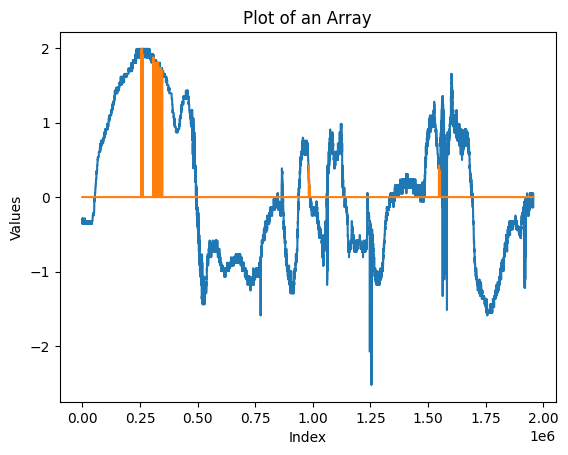

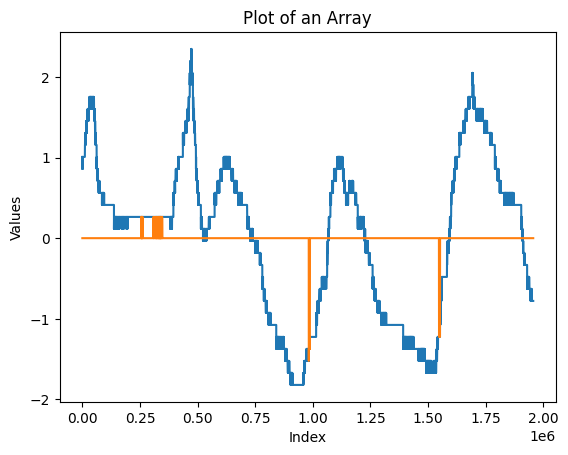

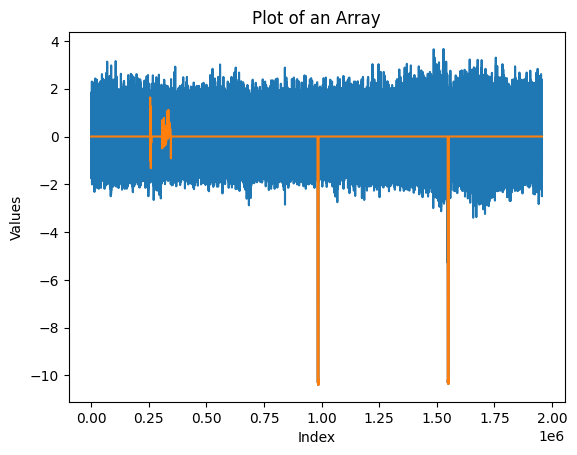

In [ ]:
for sensorName in targetName:
  y_threshold = [ testSample[0][sensorName].values[i+5] if y >7.5 else 0 for i,y in enumerate(l2_norm)]
  # plt.plot(y_threshold)

  # # Adding labels and title
  # plt.xlabel('Index')
  # plt.ylabel('Values')
  # plt.title('Plot of an Array')

  # # Display the plot
  # plt.show()

  plt.plot(testSample[0][sensorName].values)
  plt.plot(y_threshold)
  # Adding labels and title
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title('Plot of an Array')

  # Display the plot
  plt.show()